# Spin-up phase

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from tqdm.notebook import tqdm

In [3]:
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm
from matplotlib.offsetbox import AnchoredText

In [4]:
import iris.plot as iplt
import iris.quickplot as qplt
from ipywidgets import interact
from iris.analysis.maths import apply_ufunc

In [5]:
# My packages and local scripts
import aeolus

print(aeolus.__version__)
from aeolus.calc import (
    abs_coord_mean,
    d_dz,
    deriv,
    div_h,
    dry_lapse_rate,
    integrate,
    meridional_mass_streamfunction,
    meridional_mean,
    precip_sum,
    region_mean_diff,
    spatial,
    spatial_mean,
    superrotation_index,
    time_mean,
    vertical_mean,
    water_path,
    zonal_mean,
)
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import (
    coord_to_cube,
    get_cube_rel_days,
    get_xy_coords,
    interp_cube_from_height_to_pressure_levels,
    interp_cubelist_from_height_to_pressure_levels,
    isel,
)
from aeolus.core import AtmoSim
from aeolus.io import load_data, save_cubelist
from aeolus.meta import const_from_attrs, update_metadata
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    fmt_lonlat,
    label_global_map_gridlines,
    subplot_label_generator,
    tex2cf_units,
)
from aeolus.region import Region
from aeolus.subset import DimConstr, extract_last_n_days, l_range_constr

0.4.13+22.g6e7cfd9


In [6]:
import mypaths
from pouch.clim_diag import (
    KURTOSIS,
    calc_derived_cubes,
    d_dphi,
    last_500d,
    latent_heating_rate,
    latitude_of_max_zonal_wind,
    longitude_of_wave_crest,
    mean_dry_lapse_rate,
    ratio_of_dn_to_eq_pole_temp_diff,
    rolling_mean,
)
from pouch.path import lsdir
from pouch.plot import (
    KW_AUX_TTL,
    KW_AXGR,
    KW_CART,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    KW_ZERO_LINE,
    XLOCS,
    YLOCS,
    add_aux_yticks,
    draw_scalar_cube,
    draw_vector_cubes,
    figsave,
    linspace_pm1,
    make_map_figure,
    use_style,
)

In [7]:
# from zonal_momentum_budget import ZonalMomBudgetFluxForm
from angular_momentum_budget import AngularMomentumBudget
from commons import (
    DAYSIDE,
    GLM_SUITE_ID,
    NIGHTSIDE,
    SIM_LABELS,
    SS_PM15,
    as_lon,
    cold_traps,
    eq_lat,
    free_troposphere,
    mid_lat,
    midlatitudes,
    ss_lon,
    tropics,
    troposphere,
    upper_troposphere,
)

In [8]:
KW_ROLL_MEAN = dict(window=10, cutoff=0.2)

In [9]:
use_style()

bg_color = mpl.colors.to_rgb(plt.rcParams["figure.facecolor"])
fg_color = mpl.colors.to_rgb(plt.rcParams["text.color"])

In [10]:
SIM_LABELS = {
    "base": {"planet": "hab1", "title": "Base", "kw_plt": {"color": "C0"}},
    "sens-t280k": {"planet": "hab1", "title": "T0_280", "kw_plt": {"color": "C1"}},
    # "sens-t250k": {"planet": "hab1", "title": "T0_250", "kw_plt": {"color": "C2"}},
    # "sens-t260k": {"planet": "hab1", "title": "T0_260", "kw_plt": {"color": "C3"}},
    # "sens-t270k": {"planet": "hab1", "title": "T0_270", "kw_plt": {"color": "C4"}},
    # "sens-t290k": {"planet": "hab1", "title": "T0_290", "kw_plt": {"color": "C5"}},
    # "sens-noradcld": {"planet": "hab1", "title": "CRE_off", "kw_plt": {"color": "C3"}},
    "sens-fixedsst": {"planet": "hab1", "title": "FixedSST", "kw_plt": {"color": "C6"}},
}

In [11]:
img_prefix = f"{GLM_SUITE_ID}_spinup"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_spinup"
time_prof = "mean_days0_499"
plotdir = mypaths.plotdir / img_prefix

In [12]:
# Load processed data
runs = {}
runs_p = {}
for sim_label, sim_prop in tqdm(SIM_LABELS.items()):
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Derive additional fields
    calc_derived_cubes(cl, const=const, model=um)
    # Use the cube list to initialise an AtmoSim object
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="z",
    )
    # cl_p = load_data(inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}_plev.nc")
    # runs_p[sim_label] = AtmoSim(
    #     cl_p,
    #     name=sim_label,
    #     planet=planet,
    #     const_dir=mypaths.constdir,
    #     timestep=cl[0].attributes["timestep"],
    #     model=um,
    #     vert_coord="p",
    # )

  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
# runs = {k: AngularMomentumBudget.from_parent_class(v) for k, v in runs.items()}

---

In [14]:
day_start = 0
day_end = 150
day_constr = iris.Constraint(
    **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
)
tm_suffix = f"day{day_start:03d}-{day_end:03d}_mean"

In [15]:
# runs = {k: v.extract(day_constr) for k, v in runs.items()}

## TODO
### time series of dayside averages
- heating rates
- ~~day-night temperature contrast~~
- SS or dayside static stability
- ~~Convective precip or convective indicator~~
- ~~Divergence in the mid troposphere: basically the same~~

In [16]:
VRBL_PLOT = {
    "t_sfc_ep_diff": {
        "recipe": lambda AS: spatial_mean(
            AS.t_sfc.extract(iris.Constraint(**{um.y: lambda x: abs(x.point) <= 5}))
        )
        - spatial_mean(
            AS.t_sfc.extract(iris.Constraint(**{um.y: lambda x: abs(x.point) >= 85}))
        ),
        "title": "Equator-pole surface temperature difference",
        "short_title": r"$\Delta T^{sfc}_{ep}$",
        "tex_units": "$K$",
        # "lim": [5, 50],
        "fmt": lambda x: f"{x:.1f}",
    },
    # "t_sfc_d": {
    #     "recipe": lambda AS: spatial_mean(AS.t_sfc.extract(DAYSIDE.constraint)),
    #     "title": "Day side surface temperature",
    #     "short_title": r"$T^{sfc}_{d}$",
    #     "tex_units": "$K$",
    #     # "lim": [5, 50],
    #     "fmt": lambda x: f"{x:.1f}",
    # },
    # "t_sfc_n": {
    #     "recipe": lambda AS: spatial_mean(AS.t_sfc.extract(NIGHTSIDE.constraint)),
    #     "title": "Night side surface temperature",
    #     "short_title": r"$T^{sfc}_{n}$",
    #     "tex_units": "$K$",
    #     # "lim": [5, 50],
    #     "fmt": lambda x: f"{x:.1f}",
    # },
    # "div_h_up_trop": {
    #     "recipe": lambda AS: spatial_mean(
    #         vertical_mean(
    #             div_h(
    #                 AS.u.extract(ss_region.constraint & l_range_constr(6, 9)),
    #                 AS.v.extract(ss_region.constraint & l_range_constr(6, 9)),
    #             )
    #         )
    #     ),
    #     "title": "Foo",
    #     "short_title": r"$\nabla\cdot \vec{v}$",
    #     "tex_units": "$s-1$",
    #     # "lim": [5, 50],
    #     "fmt": lambda x: f"{x:.1f}",
    # },
    "ratio_dn_ep_temp_diff_trop": {
        "recipe": lambda AS: ratio_of_dn_to_eq_pole_temp_diff(AS.extract(troposphere)),
        "title": "Ratio of the day-night to\nequator-pole temperature difference",
        "short_title": r"$\Delta T_{dn}/\Delta T_{ep}$",
        "tex_units": "1",
        "lim": [0, 2.5],
        "fmt": lambda x: f"{x:.1f}",
    },
    # "t_sfc_dn_diff": {
    #     "recipe": lambda AS: region_mean_diff(AS._cubes, um.t_sfc, DAYSIDE, NIGHTSIDE),
    #     # "recipe": lambda AS: region_mean_diff(AS._cubes, um.t_sfc, SS_PM15, Region(-160, -140, 45, 55)),
    #     "title": "Day-night surface temperature difference",
    #     "short_title": r"$\Delta T^{sfc}_{dn}$",
    #     "tex_units": "$K$",
    #     # "lim": [5, 50],
    #     "fmt": lambda x: f"{x:.1f}",
    # },
    "w_trop": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.w.extract(SS_PM15.constraint & l_range_constr(0, 10)),
            )
        ),
        "title": "W",
        "short_title": r"$w$",
        "tex_units": "$m$ $s-1$",
        # "lim": [5, 50],
        "fmt": lambda x: f"{x:.1f}",
    },
    "u_mean_eq_up_trop": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.u.extract(eq_lat & l_range_constr(7, 13)),
            )
        ),
        "title": "Mean zonal wind at the equator in the upper troposphere",
        # "short_title": r"$u$",
        "tex_units": "$m$ $s-1$",
        # "lim": [5, 50],
        "fmt": lambda x: f"{x:.1f}",
    },
    "wvp_pm15deg": {
        "recipe": lambda AS: spatial_mean(
            water_path(AS._cubes.extract(SS_PM15.constraint))
        ),
        "title": "Water vapour path",
        "tex_units": "$kg$ $m^{-2}$",
        # "lim": [5, 50],
        "fmt": lambda x: f"{x:.1f}",
    },
    "jet_lat_free_trop": {
        "recipe": lambda AS: latitude_of_max_zonal_wind(AS.u.extract(free_troposphere)),
        "title": "Latitude of the tropospheric jet",
        "short_title": "$\phi_{u_{max}}$",
        "tex_units": "$\degree$",
        "lim": [0, 90],
        "ticks": [0, 30, 60, 90],
        "fmt": lambda x: f"{x:.1f}",
    },
    # "precip_conv": {
    #     "recipe": lambda AS: spatial_mean(
    #         precip_sum(AS._cubes.extract(SS_PM15.constraint), ptype="conv")
    #     ),
    #     "title": "precip conv",
    #     "short_title": "$\phi_{u_{max}}$",
    #     "tex_units": "$mm$ $day^{-1}$",
    #     "lim": [0, 40],
    #     "fmt": lambda x: f"{x:.1f}",
    # },
    # "precip_stra": {
    #     "recipe": lambda AS: spatial_mean(
    #         precip_sum(AS._cubes.extract(SS_PM15.constraint), ptype="stra")
    #     ),
    #     "title": "precip stra",
    #     "short_title": "$\phi_{u_{max}}$",
    #     "tex_units": "$mm$ $day^{-1}$",
    #     "lim": [0, 40],
    #     "fmt": lambda x: f"{x:.1f}",
    # },
    "precip_tot_pm15deg": {
        "recipe": lambda AS: spatial_mean(
            precip_sum(AS._cubes.extract(SS_PM15.constraint), ptype="total")
        ),
        "title": "Total precipitation at the SS region ($0\pm 15\degree$)",
        "tex_units": "$mm$ $day^{-1}$",
        "lim": [0, 60],
        "fmt": lambda x: f"{x:.1f}",
    },
    "dt_rad_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                sum(
                    [
                        AS[i].extract(troposphere & DAYSIDE.constraint)
                        for i in ["dt_sw", "dt_lw"]
                    ]
                ),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean SW+LW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_sw_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_sw.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean SW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_sw_cs_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_sw_cs.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean SW CS heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lw_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_lw.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean LW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lw_cs_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_lw_cs.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean LW CS heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_diab_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                sum(
                    [
                        AS[i].extract(troposphere & DAYSIDE.constraint)
                        for i in ["dt_sw", "dt_lw", "dt_bl", "dt_lsppn", "dt_cv"]
                    ]
                ),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean diabatic heating (SW+LW+BL+LSPPN+CV)",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lh_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                sum(
                    [
                        AS[i].extract(troposphere & DAYSIDE.constraint)
                        for i in ["dt_bl", "dt_lsppn", "dt_cv"]
                    ]
                ),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean latent heating (BL+LSPPN+CV)",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_bl_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_bl.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean BL heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lsppn_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_lsppn.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean LSPPN heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_cv_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_cv.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean CV heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_dz_trop_pm15deg": {
        "recipe": lambda AS: spatial_mean(
            mean_dry_lapse_rate(
                AS._cubes.extract(troposphere & SS_PM15.constraint),
            )
        ),
        "title": "Lapse rate",
        "short_title": r"$dT/dz$",
        "tex_units": "$K$ $km^{-1}$",
        "fmt": "3.1f",
    },
    "toa_alb_cs": {
        "recipe": lambda AS: spatial_mean(
            (AS.toa_osr_cs / AS.toa_isr).extract(
                iris.Constraint(**{um.y: lambda x: abs(x.point) >= 75})
                & DAYSIDE.constraint
            )
        ),
        "title": "TOA SW CS albedo",
        "short_title": r"$\alpha_p = F^{TOA}_{OSR,CS} / F^{TOA}_{ISR}$",
        "tex_units": "%",
        # "lim": [0, 15],
        "fmt": lambda x: f"{x:.1f}",
    },
    "toa_alb": {
        "recipe": lambda AS: spatial_mean(
            (AS.toa_osr / AS.toa_isr).extract(DAYSIDE.constraint)
        ),
        "title": "TOA SW albedo",
        "short_title": r"$\alpha_p = F^{TOA}_{OSR} / F^{TOA}_{ISR}$",
        "tex_units": "%",
        # "lim": [0, 60],
        "fmt": lambda x: f"{x:.1f}",
    },
    "sfc_alb": {
        "recipe": lambda AS: spatial_mean(
            ((AS.sfc_dn_sw - AS.sfc_net_down_sw) / AS.sfc_dn_sw).extract(
                iris.Constraint(**{um.y: lambda x: abs(x.point) >= 45})
                & DAYSIDE.constraint
            )
        ),
        "title": "Surface SW albedo",
        "short_title": r"$\alpha_p = F^{sfc}_{OSR} / F^{sfc}_{ISR}$",
        "tex_units": "%",
        # "lim": [0, 60],
        "fmt": lambda x: f"{x:.1f}",
    },
    "dt_dz_trop_pm15deg": {
        "recipe": lambda AS: spatial_mean(
            mean_dry_lapse_rate(
                AS._cubes.extract(troposphere & SS_PM15.constraint),
            )
        ),
        "title": "Lapse rate",
        "short_title": r"$dT/dz$",
        "tex_units": "$K$ $km^{-1}$",
        "fmt": "3.1f",
    },
}

In [22]:
# vrbls_to_show = ["toa_alb", "wvp_pm15deg", "precip_tot_pm15deg", "w_trop"]
# vrbls_to_show = ["dt_diab_d", "dt_rad_d", "dt_lh_d"]
# vrbls_to_show = ["dt_rad_d", "dt_sw_d", "dt_lw_d", "dt_sw_cs_d", "dt_lw_cs_d"]
# vrbls_to_show = ["dt_lh_d", "dt_bl_d", "dt_lsppn_d", "dt_cv_d"]
# vrbls_to_show = ["dt_dz_trop_pm15deg", "t_sfc_ep_diff"]
# vrbls_to_show = ["toa_alb", "toa_alb_cs"]
# vrbls_to_show = ["sfc_alb"]

In [23]:
RESULTS = {}
caught_errors = []
for vrbl_key in tqdm(vrbls_to_show):
    vrbl_prop = VRBL_PLOT[vrbl_key]
    RESULTS[vrbl_key] = {}
    for sim_label in tqdm(SIM_LABELS.keys(), leave=False):
        if vrbl_prop.get("source", "") == "p":
            the_run = runs_p[sim_label].extract(day_constr)
        else:
            the_run = runs[sim_label].extract(day_constr)

        # Calculate diagnostics
        cube = vrbl_prop["recipe"](the_run)
        try:
            cube.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
        except ValueError as e:
            caught_errors.append(f"{vrbl_key}: {e}")
        RESULTS[vrbl_key][sim_label] = cube
if caught_errors:
    print(caught_errors)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k_sens-fixedsst__tseries__dt_diab_d_dt_rad_d_dt_lh_d__day000-150_mean.png


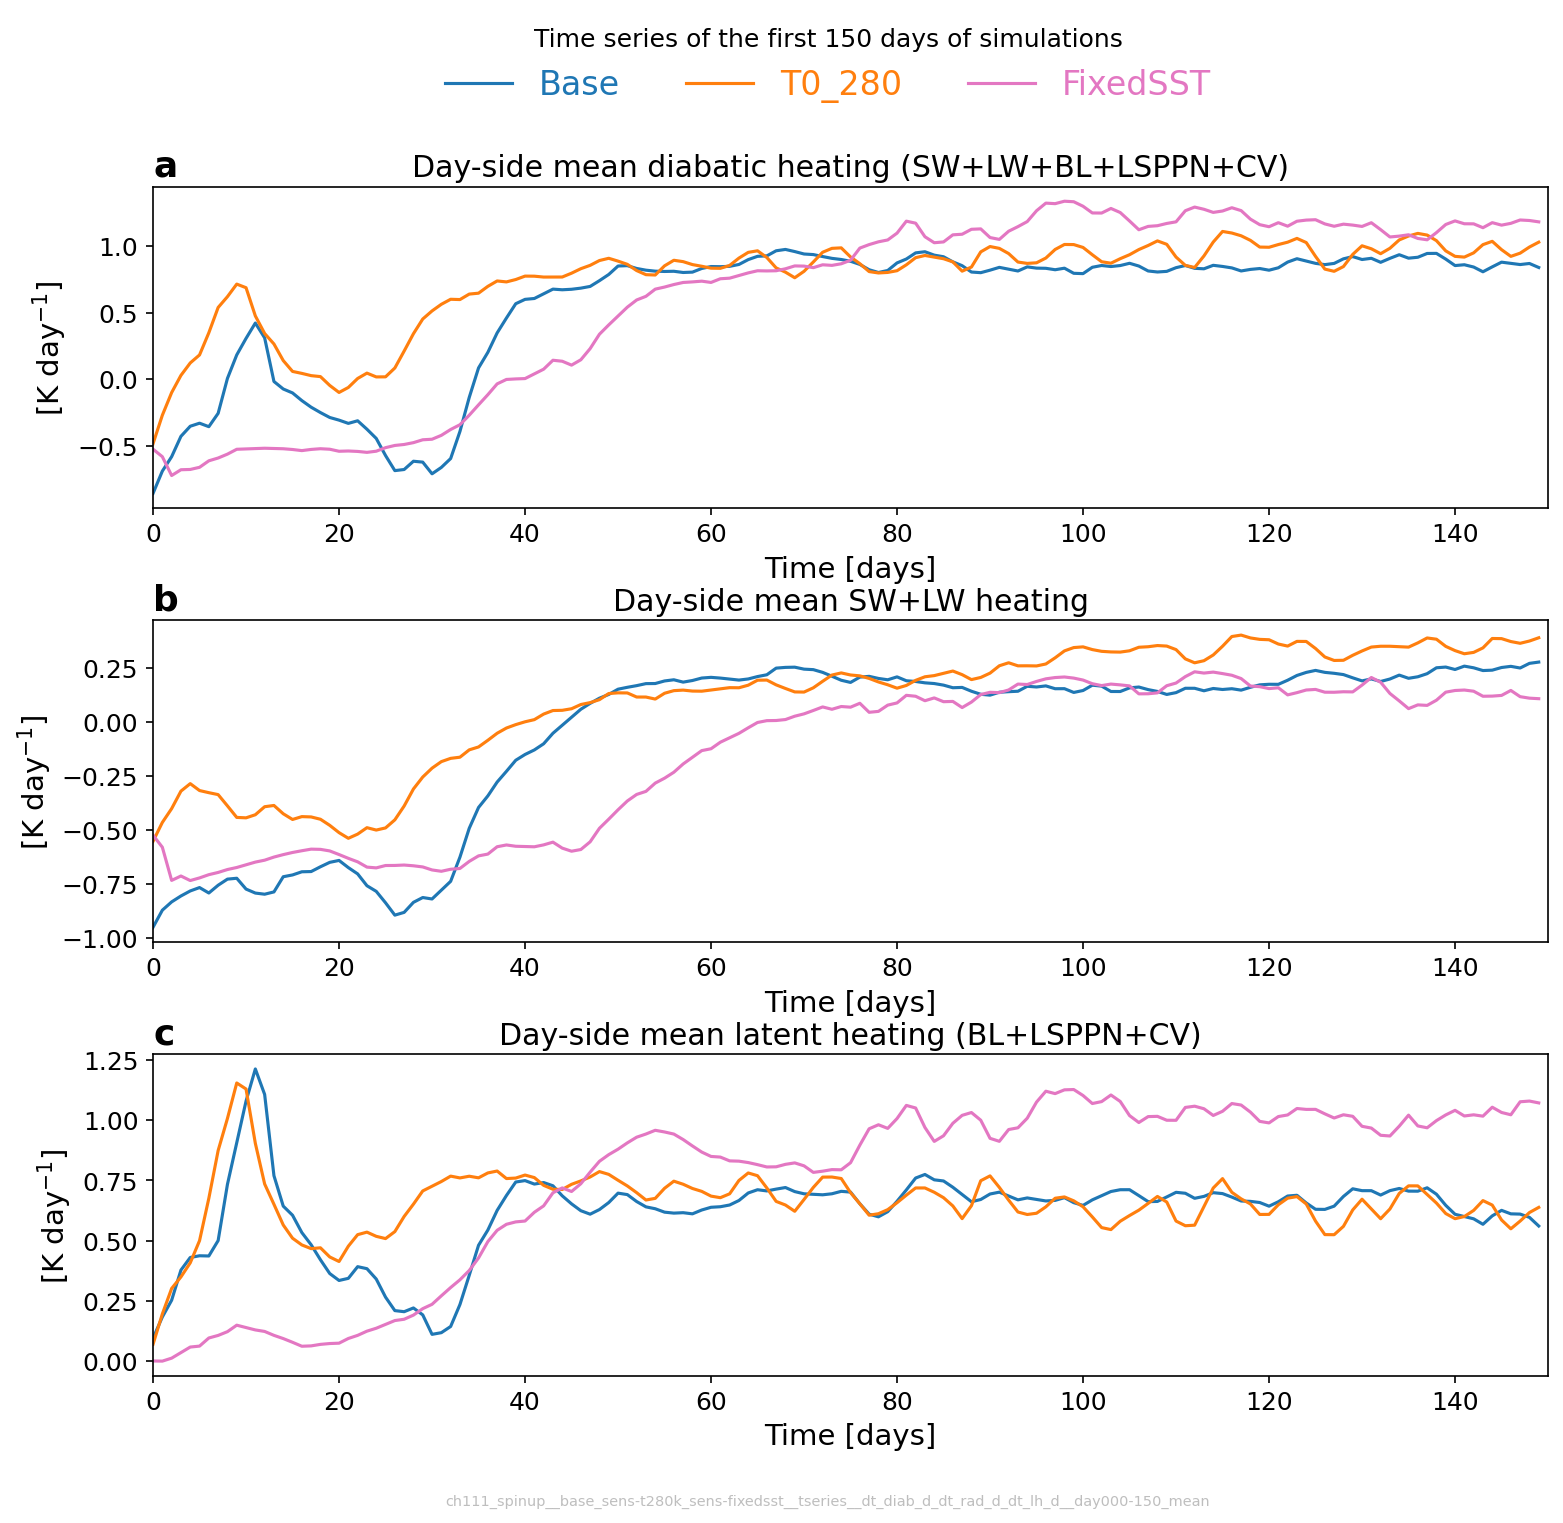

In [24]:
nrows = len(vrbls_to_show)
ncols = 1

fig = plt.figure(figsize=(ncols * 12, nrows * 3.5))
axd = fig.subplot_mosaic(
    [[vrbl_key] for vrbl_key in vrbls_to_show], gridspec_kw={"hspace": 0.35}
)  # show bottom first

if len(axd) > 1:
    iletters = subplot_label_generator()
    for ax in axd.values():
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
for vrbl_key in vrbls_to_show:
    vrbl_prop = VRBL_PLOT[vrbl_key]
    ax = axd[vrbl_key]
    ttl = vrbl_prop["title"]
    if short_ttl := vrbl_prop.get("short_title"):
        # ttl += f" ({short_ttl})"
        ax.set_title(short_ttl, **KW_AUX_TTL)
    ax.set_title(ttl, **KW_MAIN_TTL)
    ax.set_xlim(day_start, day_end)
    # if ax.get_subplotspec().is_last_row():
    ax.set_xlabel("Time [days]")
    if (tex_units := vrbl_prop["tex_units"]) not in ["1", None]:
        ax.set_ylabel(f"[{tex_units}]")
    if lim := vrbl_prop.get("lim"):
        ax.set_ylim(lim)
    for sim_label, sim_prop in SIM_LABELS.items():
        cube = RESULTS[vrbl_key][sim_label]
        ax.plot(get_cube_rel_days(cube), cube.data, **sim_prop["kw_plt"])
add_custom_legend(
    fig,
    {sim_prop["title"]: sim_prop["kw_plt"] for sim_prop in SIM_LABELS.values()},
    loc="upper center",
    bbox_to_anchor=(0.5, 1.0),
    frameon=False,
    ncol=min(3, len(SIM_LABELS)),
    title=f"Time series of the first {day_end} days of simulations",
)
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS)}__tseries__{'_'.join(vrbls_to_show)}__{tm_suffix}"
figsave(fig, plotdir / imgname)

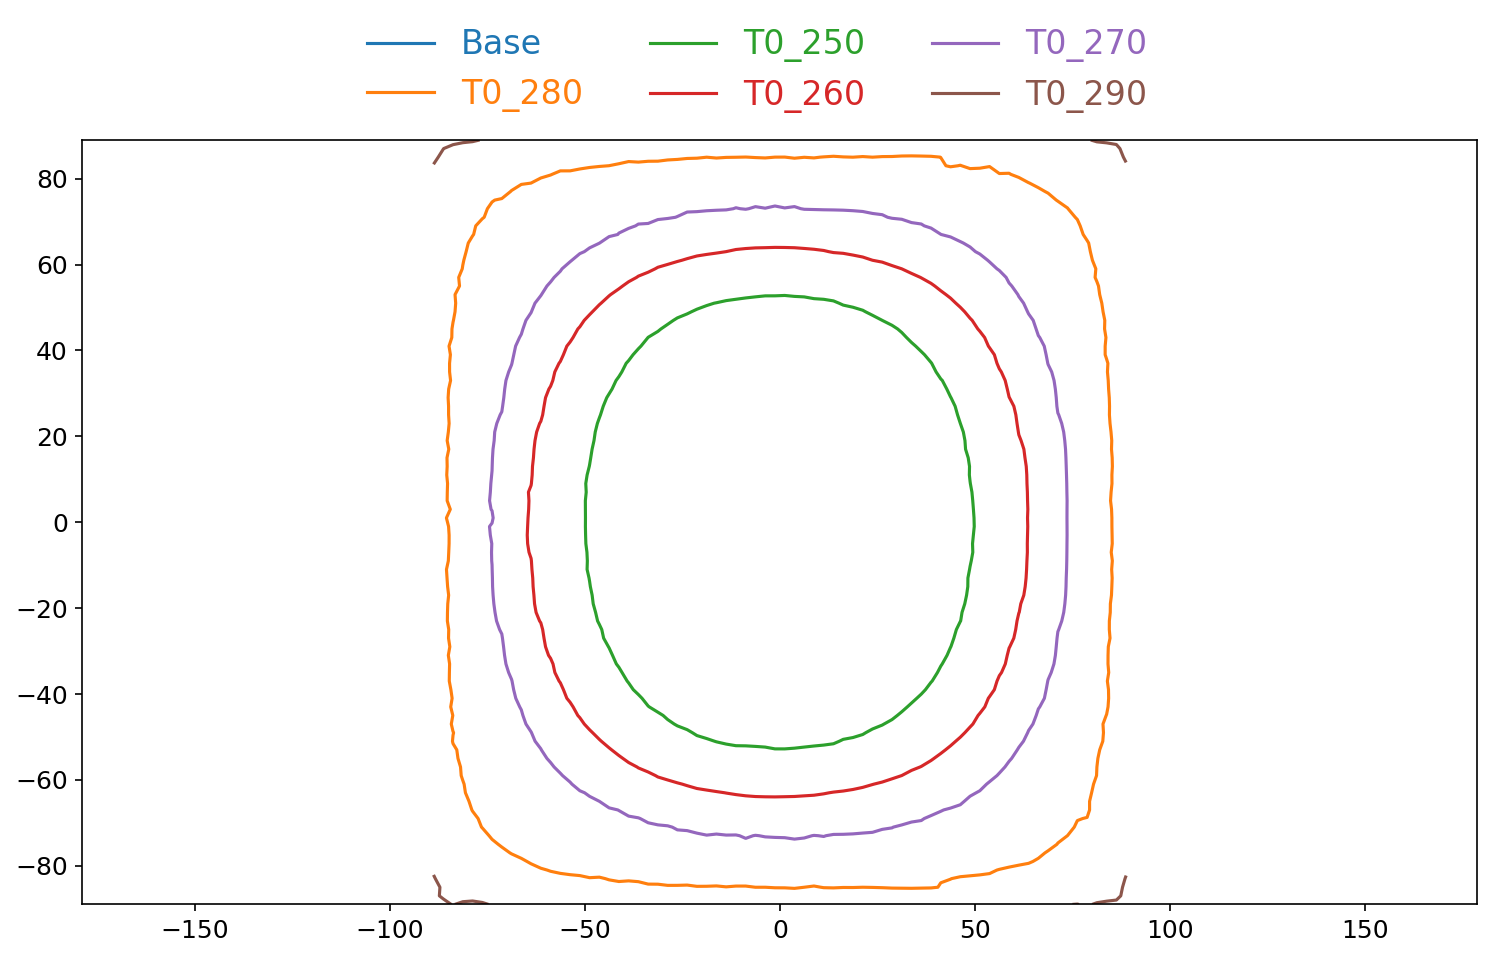

In [56]:
fig, ax = plt.subplots()
for sim_label, sim_prop in SIM_LABELS.items():
    the_run = runs[sim_label]
    sfc_alb = (the_run.sfc_dn_sw - the_run.sfc_net_down_sw) / the_run.sfc_dn_sw
    sfc_alb = time_mean(sfc_alb.extract(t_constr))

    ax.contour(
        sfc_alb.coord(um.x).points,
        sfc_alb.coord(um.y).points,
        sfc_alb.data,
        levels=[0.2],
        colors=sim_prop["kw_plt"]["color"],
    )

add_custom_legend(
    fig,
    {sim_prop["title"]: sim_prop["kw_plt"] for sim_prop in SIM_LABELS.values()},
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),
    frameon=False,
    ncol=min(3, len(SIM_LABELS)),
    # title=f"Time series of the first {day_end} days of simulations",
)

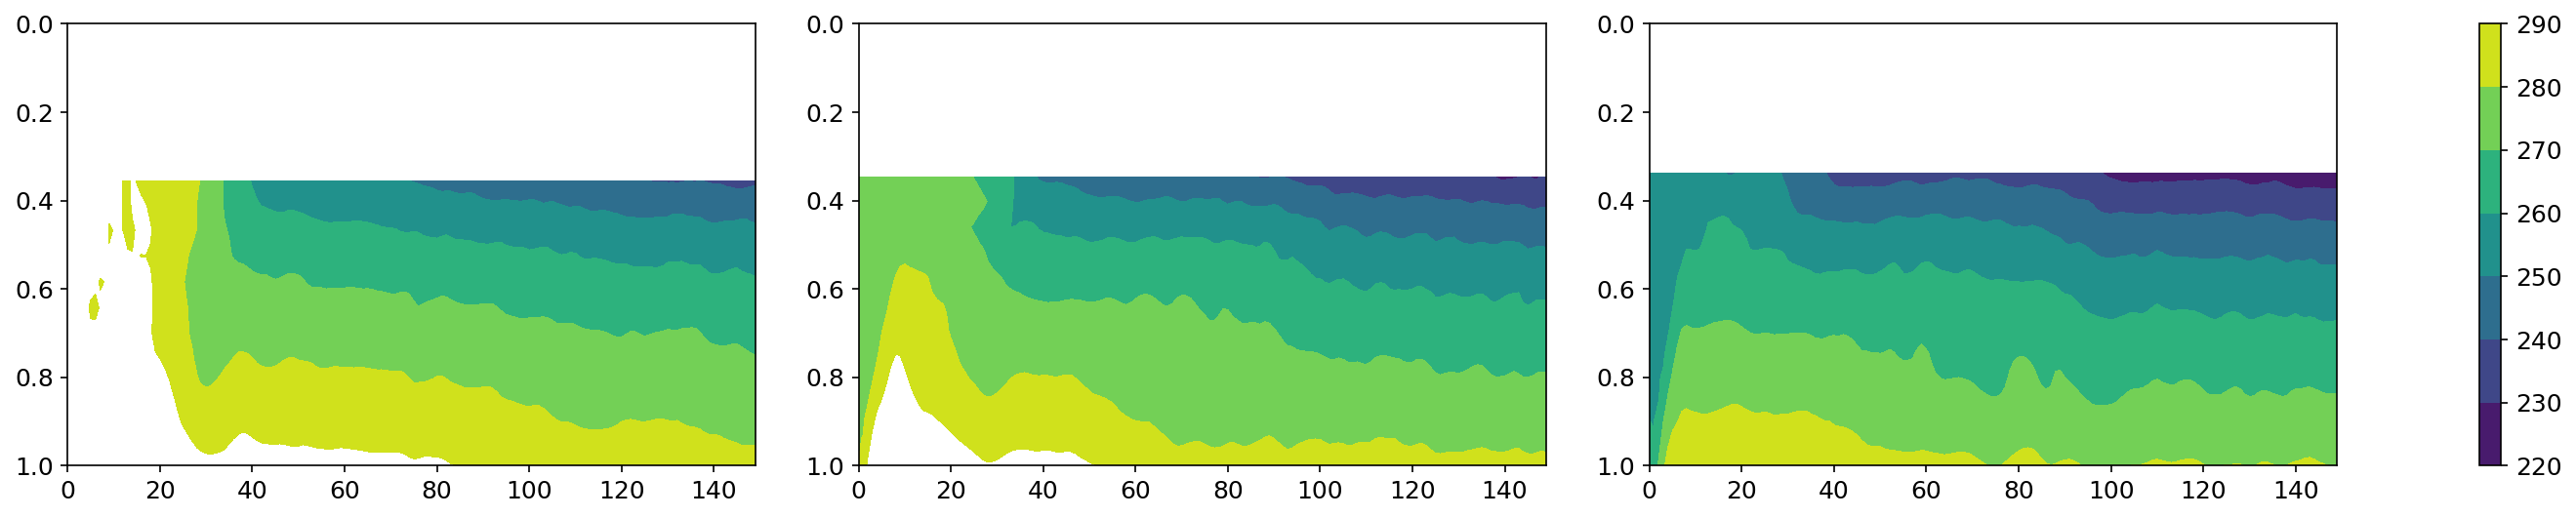

In [27]:
ncols = len(SIM_LABELS)
nrows = 1

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(25, 4),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
    squeeze=True,
)
for ax, sim_label in zip(axs, SIM_LABELS.keys()):
    ax.set_ylim(1, 0)
    the_run = runs[sim_label].extract(day_constr)

    # cube = sum([the_run.dt_sw, the_run.dt_lw, the_run.dt_bl, the_run.dt_lsppn, the_run.dt_cv])
    cube = spatial_mean(
        the_run.temp.extract(SS_PM15.constraint & l_range_constr(0, 10))
    )

    x = get_cube_rel_days(cube)
    y = spatial_mean(
        time_mean(the_run.sigma_p.extract(SS_PM15.constraint & l_range_constr(0, 10)))
    ).data
    _p0 = ax.contourf(
        x,
        y,
        cube.data.T,
        levels=np.arange(220, 291, 10)
        # , cmap=cm.vik, levels=linspace_pm1(10) * 6e-5
    )
fig.colorbar(_p0, ax=axs)

---

### Wave shift and the emergence of superrotation

In [14]:
P_LEV = 300  # hPa
p_lev_constr = iris.Constraint(**{um.pres: P_LEV * 1e2})

In [18]:
# srot_idx = spatial_mean(
#     superrotation_index(
#         runs_p[sim_label]._cubes.extract(um.u).extract(p_lev_constr & tropics)
#     )
# )

In [16]:
@update_metadata(name="amplitude_of_wave_crest", units="m^2 s^-2")
def amplitude_of_wave_crest(g_height, model=um):
    """Determine the amplitude of the geopotential height anomaly maximum."""
    # Get the deviation from the zonal mean
    g_height_anom = g_height - zonal_mean(g_height, model=model)
    # Select only extratropical latitudes
    g_height_anom_et = g_height_anom.extract(
        iris.Constraint(**{um.y: lambda x: 30 <= abs(x.point) <= 65})
    )
    # Average over latitudes
    g_height_anom_et_mmean = meridional_mean(g_height_anom_et)
    # Find maximum
    out = spatial(g_height_anom_et_mmean, "max")
    return out

In [33]:
T_VRBL_PLOT = {
    "u_eq_jet_max": {
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "max"),
        "method": "plot",
        "kw_plt": dict(
            color="tab:brown",
        ),
        "title": "Zonal wind at the equator",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [0, 110],
    },
    # "wave_crest_lon": {
    #     "cube": lambda AS: longitude_of_wave_crest(AS.ghgt.extract(p_lev_constr)),
    #     "method": "plot",
    #     "kw_plt": dict(
    #         color="tab:cyan",
    #     ),
    #     "title": "Longitude of the wave crest",
    #     "tex_units": "$\degree$",
    #     "lim": [-150, 100],
    #     "ticks": [-150, -90, -45, 0, 45, 90],
    # },
    "wave_amplitude": {
        "cube": lambda AS: amplitude_of_wave_crest(AS.ghgt.extract(p_lev_constr))
        / AS.const.gravity,
        "method": "plot",
        "kw_plt": dict(
            color="tab:purple",
        ),
        "title": "Wave amplitude",
        "tex_units": "$m$",
        "lim": [0, 500],
    },
}

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k__u_eq_jet_max_wave_amplitude_300hpa.png


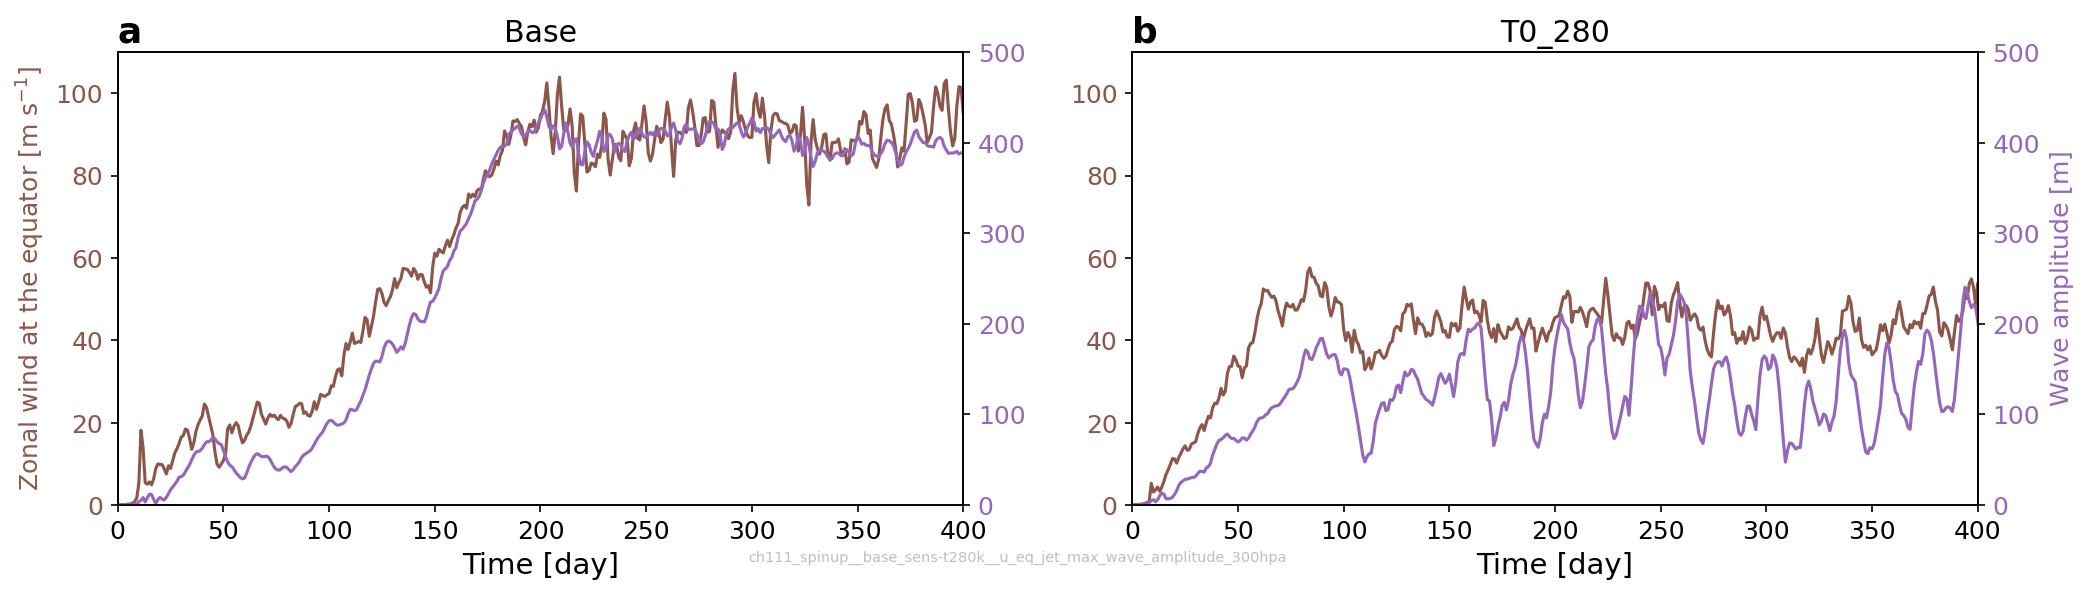

In [34]:
imgname = (
    f"{img_prefix}__{'_'.join(SIM_LABELS)}__{'_'.join(T_VRBL_PLOT.keys())}_{P_LEV}hpa"
)
xlim = [0, 400]
ncols = 2
nrows = 1
window = 10
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4))
iletters = subplot_label_generator()

for (sim_label, sim_prop), ax in zip(SIM_LABELS.items(), axs.flat):
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_title(sim_prop["title"], **KW_MAIN_TTL)
    ax2 = ax.twinx()
    ax.set_xlabel("Time [day]")
    the_run = runs_p[f"{sim_label}"]
    for i, (_ax, (vrbl_key, vrbl_dict)) in enumerate(
        zip((ax, ax2), T_VRBL_PLOT.items())
    ):
        # Calculate diagnostics
        cube = vrbl_dict["cube"](the_run)
        cube_rm = rolling_mean(cube, um.t, window=window)
        # Plot diagnostics
        if (not _ax.is_first_col()) == i:
            _ax.set_ylabel(
                f'{vrbl_dict["title"]} [{vrbl_dict["tex_units"]}]',
                color=vrbl_dict["kw_plt"]["color"],
                fontsize="medium",
            )
        _ax.set_ylim(vrbl_dict["lim"])
        if "ticks" in vrbl_dict:
            _ax.set_yticks(vrbl_dict["ticks"])
        _ax.set_xlim(xlim)
        if i == 0:
            _ax.hlines(0, *xlim, alpha=0.25, color=vrbl_dict["kw_plt"]["color"])
        _ax.tick_params(axis="y", labelcolor=vrbl_dict["kw_plt"]["color"])
        # _ax.plot(
        #     get_cube_rel_days(cube),
        #     cube.data,
        #     linewidth=0.25,
        #     **vrbl_dict["kw_plt"],
        # )
        _ax.plot(
            get_cube_rel_days(cube),  # get_cube_rel_days(cube_rm) + window,
            cube.data,  # cube_rm.data,
            linewidth=1.5,
            **vrbl_dict["kw_plt"],
        )
figsave(fig, plotdir / imgname)

---

In [14]:
XZ_VRBL_PLOT = {
    "u": {
        "title": "Zonal wind",
        "tex_units": "$m$ $s^{-1}$",
        "func": lambda AS: time_mean(AS.u.extract(eq_lat)),
        "method": "contourf",
        "kw_plt": {
            "levels": linspace_pm1(10) * 50,
            "cmap": cm.vik,
            "extend": "both",
        },
    },
    "w": {
        "title": "Upward wind velocity",
        "tex_units": "$10^{-2}$ $m$ $s^{-1}$",
        "func": lambda AS: time_mean(AS.w.extract(eq_lat)),
        "method": "contour",
        "kw_plt": {
            "levels": linspace_pm1(20) * 10,
            "cmap": cm.broc,
        },
    },
}

In [15]:
day_half_window = 5
day_middle_list = np.arange(0, 5) * day_half_window * 2 + day_half_window
time_suffix = f"{'_'.join(str(i) for i in day_middle_list)}_days_mean"
print(time_suffix)
day_middle_list - day_half_window, day_middle_list + day_half_window

5_15_25_35_45_days_mean


(array([ 0, 10, 20, 30, 40]), array([10, 20, 30, 40, 50]))

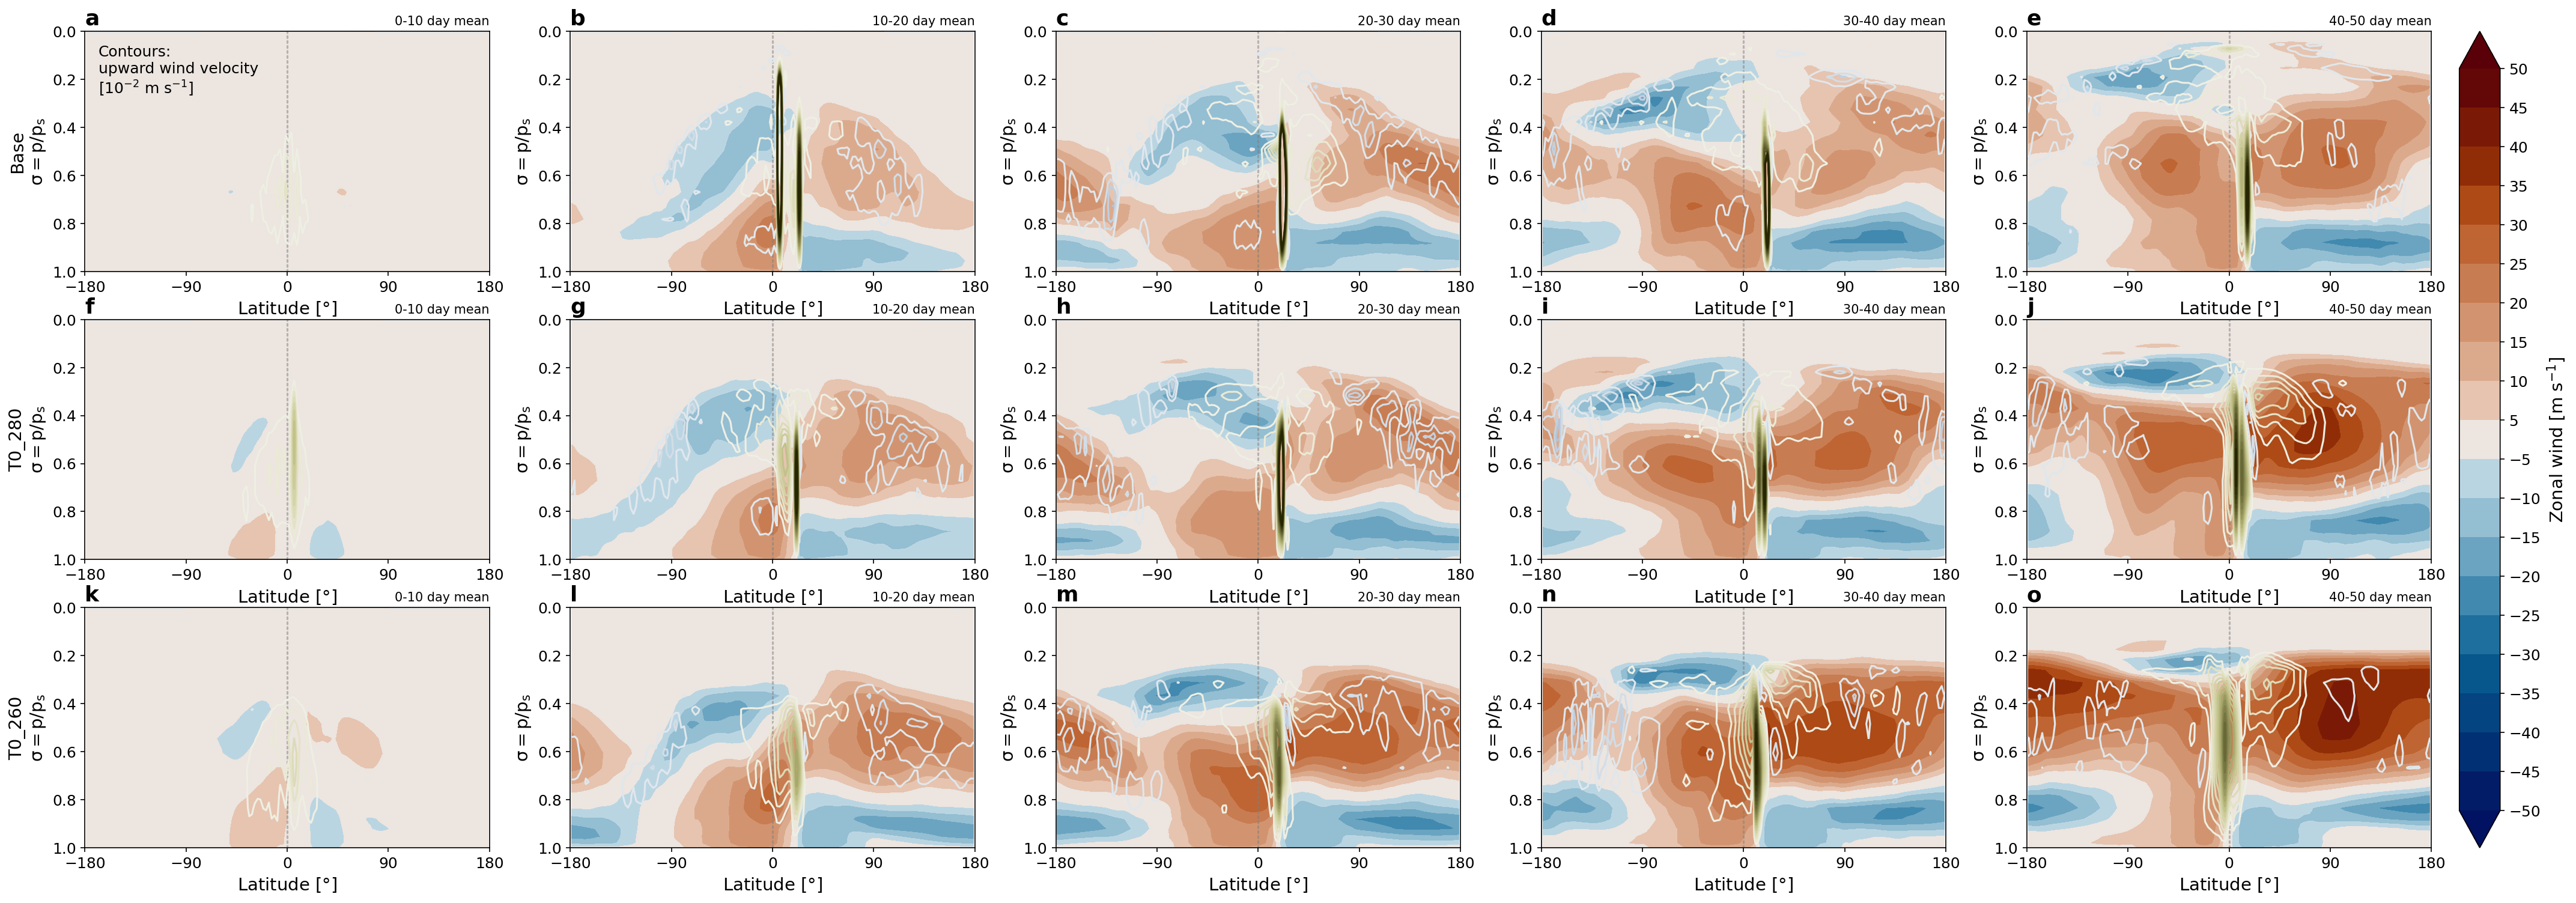

In [16]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__{'_'.join(XZ_VRBL_PLOT.keys())}_{time_suffix}"

ncols = len(day_middle_list)
nrows = len(SIM_LABELS)

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4), squeeze=False
)

iletters = subplot_label_generator()
for (sim_label, sim_prop), axrow in zip(SIM_LABELS.items(), axs):
    the_run = runs[sim_label]
    _sigma_p = time_mean(spatial_mean(the_run.sigma_p))

    for ax, day_middle in zip(axrow, day_middle_list):
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        # ax.set_title(f"", **KW_MAIN_TTL)
        ax.set_ylim(1, 0)
        ax.set_xticks(XLOCS)
        ax.set_xlim(-180, 180)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"{sim_prop['title']}\n" "$\sigma=p/p_s$")
        else:
            ax.set_ylabel("$\sigma=p/p_s$")
        # if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Latitude [$\degree$]")
        ax.axvline(0, **KW_ZERO_LINE)

        day_start = day_middle - day_half_window
        day_end = day_middle + day_half_window
        day_constr = iris.Constraint(
            **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
        )
        ax.set_title(f"{day_start}-{day_end} day mean", **KW_AUX_TTL)

        for varkey, vardict in XZ_VRBL_PLOT.items():
            cube = vardict["func"](the_run.extract(day_constr))
            cube.convert_units(tex2cf_units(vardict["tex_units"]))
            p0 = getattr(ax, vardict["method"])(
                the_run.coord.x.points,
                _sigma_p.data,
                cube.data,
                **vardict["kw_plt"],
            )
            if vardict["method"] == "contour":
                ...
                # clbls = ax.clabel(p0, fmt="%.0f")
            if (
                ax.get_subplotspec().is_first_col()
                and ax.get_subplotspec().is_first_row()
            ):
                if vardict["method"] == "contour":
                    ax.add_artist(
                        AnchoredText(
                            f"Contours:\n{vardict['title'].lower()}\n[{vardict['tex_units']}]",
                            loc="upper left",
                            frameon=False,
                        )
                    )
                elif vardict["method"] == "contourf":
                    cb = fig.colorbar(p0, ax=axs, pad=0.01)
                    cb.set_ticks(vardict["kw_plt"]["levels"])
                    cb.ax.set_ylabel(f"{vardict['title']} [{vardict['tex_units']}]")

# figsave(fig, plotdir / imgname)

---

In [49]:
YZ_VRBL_PLOT = {
    "mmsf": {
        "title": "Mass meridional streamfunction",
        "tex_units": "$10^{11}$ $kg$ $s^{-1}$",
        "func": lambda AS: time_mean(meridional_mass_streamfunction(AS._cubes)),
        "method": "contourf",
        "kw_plt": {
            "levels": linspace_pm1(8) * 2,
            "cmap": "PuOr_r",
            "extend": "both",
        },
    },
    "w": {
        "title": "Upward wind velocity",
        "tex_units": "$10^{-2}$ $m$ $s^{-1}$",
        "func": lambda AS: time_mean(zonal_mean(AS.w.extract(DAYSIDE.constraint))),
        "method": "contour",
        "kw_plt": {
            "levels": linspace_pm1(8) * 2,
            "cmap": "seismic",
        },
    },
}

In [50]:
day_half_window = 25
day_middle_list = np.arange(0, 5) * day_half_window * 2 + day_half_window
time_suffix = f"{'_'.join(str(i) for i in day_middle_list)}_days_mean"
print(time_suffix)
day_middle_list - day_half_window, day_middle_list + day_half_window

25_75_125_175_225_days_mean


(array([  0,  50, 100, 150, 200]), array([ 50, 100, 150, 200, 250]))

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k__mmsf_w_25_75_125_175_225_days_mean.png


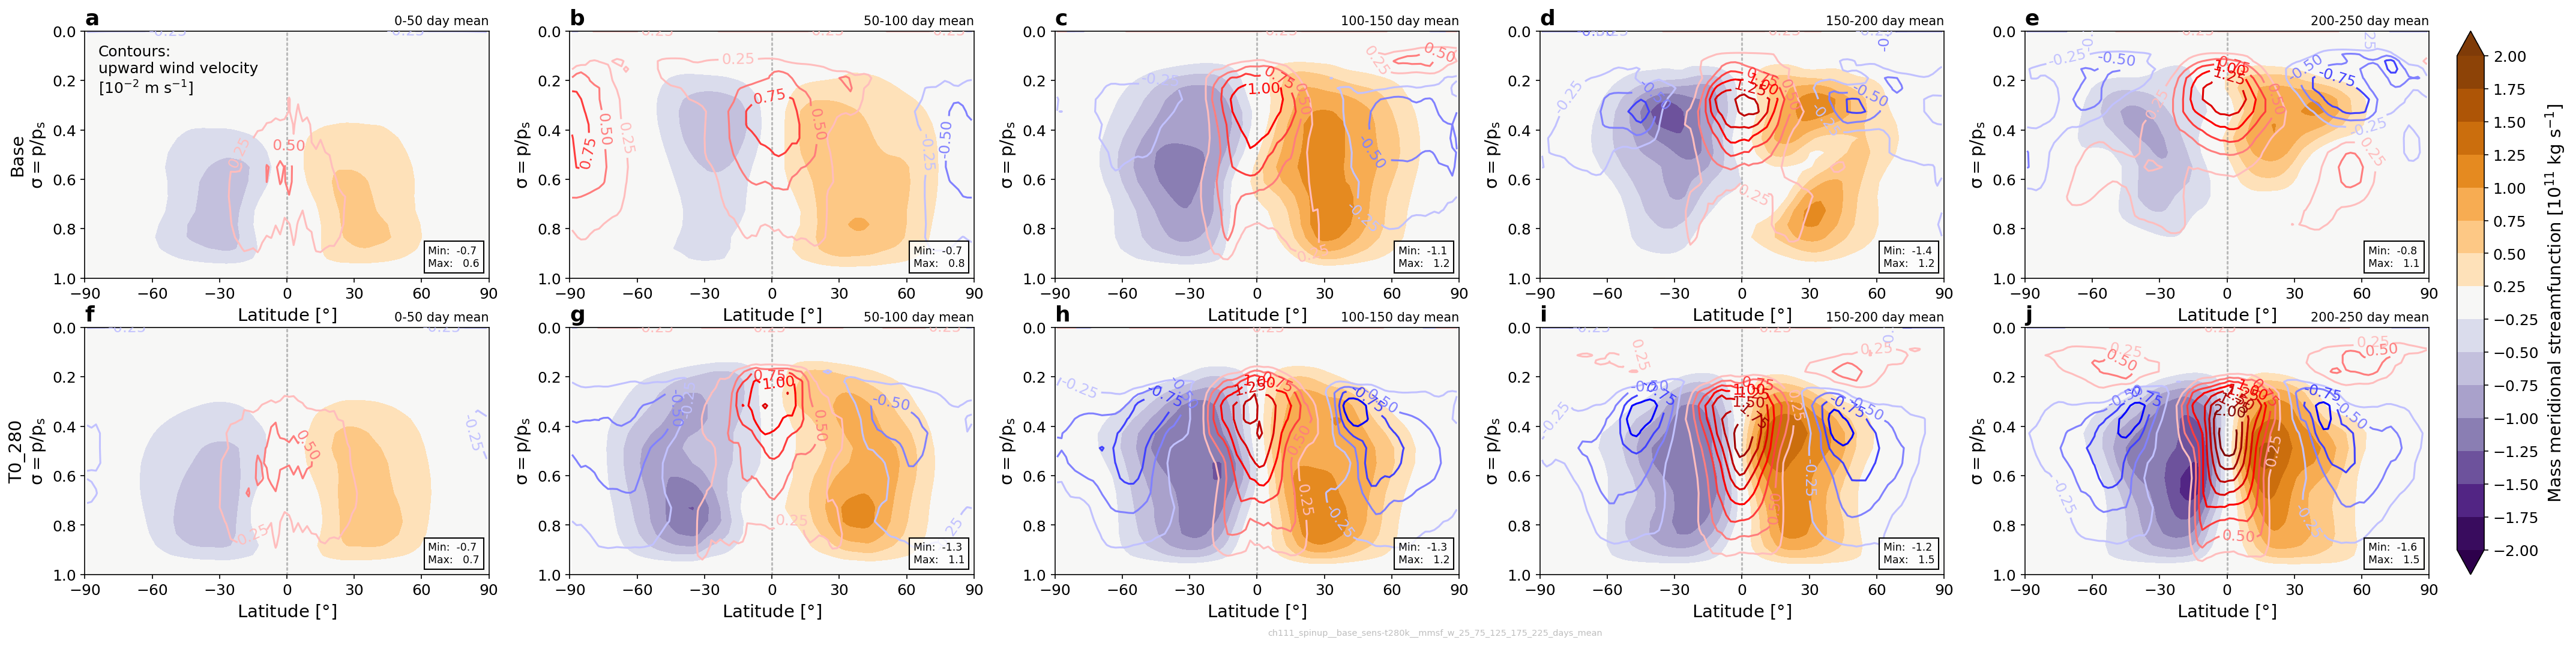

In [51]:
add_min_max = True

ncols = len(day_middle_list)
nrows = len(SIM_LABELS)

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4), squeeze=False
)

iletters = subplot_label_generator()
for (sim_label, sim_prop), axrow in zip(SIM_LABELS.items(), axs):
    the_run = runs[sim_label]
    _sigma_p = time_mean(spatial_mean(the_run.sigma_p))

    for ax, day_middle in zip(axrow, day_middle_list):
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        # ax.set_title(f"", **KW_MAIN_TTL)
        ax.set_ylim(1, 0)
        ax.set_xticks(YLOCS)
        ax.set_xlim(-90, 90)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"{sim_prop['title']}\n" "$\sigma=p/p_s$")
        else:
            ax.set_ylabel("$\sigma=p/p_s$")
        # if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Latitude [$\degree$]")
        ax.axvline(0, **KW_ZERO_LINE)

        day_start = day_middle - day_half_window
        day_end = day_middle + day_half_window
        day_constr = iris.Constraint(
            **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
        )
        ax.set_title(f"{day_start}-{day_end} day mean", **KW_AUX_TTL)

        for i, (varkey, vardict) in enumerate(YZ_VRBL_PLOT.items()):
            cube = vardict["func"](the_run.extract(day_constr))
            cube.convert_units(tex2cf_units(vardict["tex_units"]))
            p0 = getattr(ax, vardict["method"])(
                the_run.coord.y.points,
                _sigma_p.data,
                cube.data,
                **vardict["kw_plt"],
            )
            if vardict["method"] == "contour":
                clbls = ax.clabel(p0, fmt="%.2f")
            if (
                ax.get_subplotspec().is_first_col()
                and ax.get_subplotspec().is_first_row()
            ):
                if vardict["method"] == "contour":
                    ax.add_artist(
                        AnchoredText(
                            f"Contours:\n{vardict['title'].lower()}\n[{vardict['tex_units']}]",
                            loc="upper left",
                            frameon=False,
                        )
                    )
                elif vardict["method"] == "contourf":
                    cb = fig.colorbar(p0, ax=axs, pad=0.01)
                    cb.set_ticks(vardict["kw_plt"]["levels"])
                    cb.ax.set_ylabel(f"{vardict['title']} [{vardict['tex_units']}]")
            if add_min_max and i == 0:
                cube_min = cube.data.min()
                cube_max = cube.data.max()
                at = AnchoredText(
                    f"Min: {cube_min:>5.1f}\nMax: {cube_max:>5.1f}",
                    prop=dict(color="k", size="x-small"),
                    frameon=True,
                    loc="lower right",
                )
                at.patch.set_facecolor(mpl.colors.to_rgba(bg_color, alpha=0.75))
                ax.add_artist(at)

imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__{'_'.join(YZ_VRBL_PLOT.keys())}_{time_suffix}"
figsave(fig, plotdir / imgname)

#### tidally locked version

In [13]:
from aeolus.calc import (
    cumsum,
    regrid_to_tidally_locked_coordinates,
    rotate_winds_to_tidally_locked_coordinates,
)
from windspharm.iris import VectorWind

In [14]:
tl_ticks = np.arange(-90, 91, 30)
tl_ticklabels = [f"{i}" for i in tl_ticks]
tl_ticklabels[0] += "\nAS"
tl_ticklabels[-1] += "\nSS"
tl_ticklabels[len(tl_ticklabels) // 2] += "\nT"

In [15]:
@update_metadata(
    name="tidally_locked_mass_meridional_streamfunction", units="1e11 kg s-1"
)
def tidally_locked_mass_meridional_streamfunction(AS, patch_projerror=True):
    """Calculate mass meridional streamfunction in tidally locked coordinates."""
    from iris.coord_systems import GeogCS
    from iris.fileformats.pp import EARTH_RADIUS

    u = AS.u.copy()
    v = AS.v.copy()
    dens = AS.dens.copy()
    lat_cos = AS.lat_cos.copy()
    if patch_projerror:
        # >>> Temporary patch due to ProjError
        cubes = [u, v, dens, lat_cos]
        _coord_system = GeogCS(semi_major_axis=EARTH_RADIUS)
        for cube in cubes:
            for coord in cube.coords():
                if coord.coord_system:
                    # Replace coordinate system with the planet radius given in `self.const`
                    coord.coord_system = _coord_system
        # <<< Temporary patch due to ProjError

    _, v_tl = rotate_winds_to_tidally_locked_coordinates(u, v)

    v_tl = regrid_to_tidally_locked_coordinates(v_tl)
    v_tl_zm = zonal_mean(v_tl)
    dens_tl = regrid_to_tidally_locked_coordinates(dens)
    dens_tl_zm = zonal_mean(dens_tl)

    sf_tl = cumsum(v_tl_zm * dens_tl_zm, "z", True)

    sf_tl = 2 * np.pi * AS.const.radius * lat_cos * sf_tl
    return sf_tl

In [16]:
YZ_VRBL_PLOT = {
    "tlmmsf": {
        "title": "Tidally locked mass meridional streamfunction",
        "tex_units": "$10^{11}$ $kg$ $s^{-1}$",
        "func": lambda AS: time_mean(tidally_locked_mass_meridional_streamfunction(AS)),
        "method": "contourf",
        "kw_plt": {
            "levels": linspace_pm1(12) * 6,
            "cmap": "PuOr_r",
            "extend": "both",
        },
    },
    "w": {
        "title": "Upward wind velocity",
        "tex_units": "$10^{-2}$ $m$ $s^{-1}$",
        "func": lambda AS: time_mean(
            zonal_mean(regrid_to_tidally_locked_coordinates(AS.w))
        ),
        "method": "contour",
        "kw_plt": {
            "levels": linspace_pm1(16) * 8,
            "cmap": "seismic",
        },
    },
}

In [17]:
day_half_window = 25
day_middle_list = np.arange(0, 5) * day_half_window * 2 + day_half_window
time_suffix = f"{'_'.join(str(i) for i in day_middle_list)}_days_mean"
print(time_suffix)
day_middle_list - day_half_window, day_middle_list + day_half_window

25_75_125_175_225_days_mean


(array([  0,  50, 100, 150, 200]), array([ 50, 100, 150, 200, 250]))

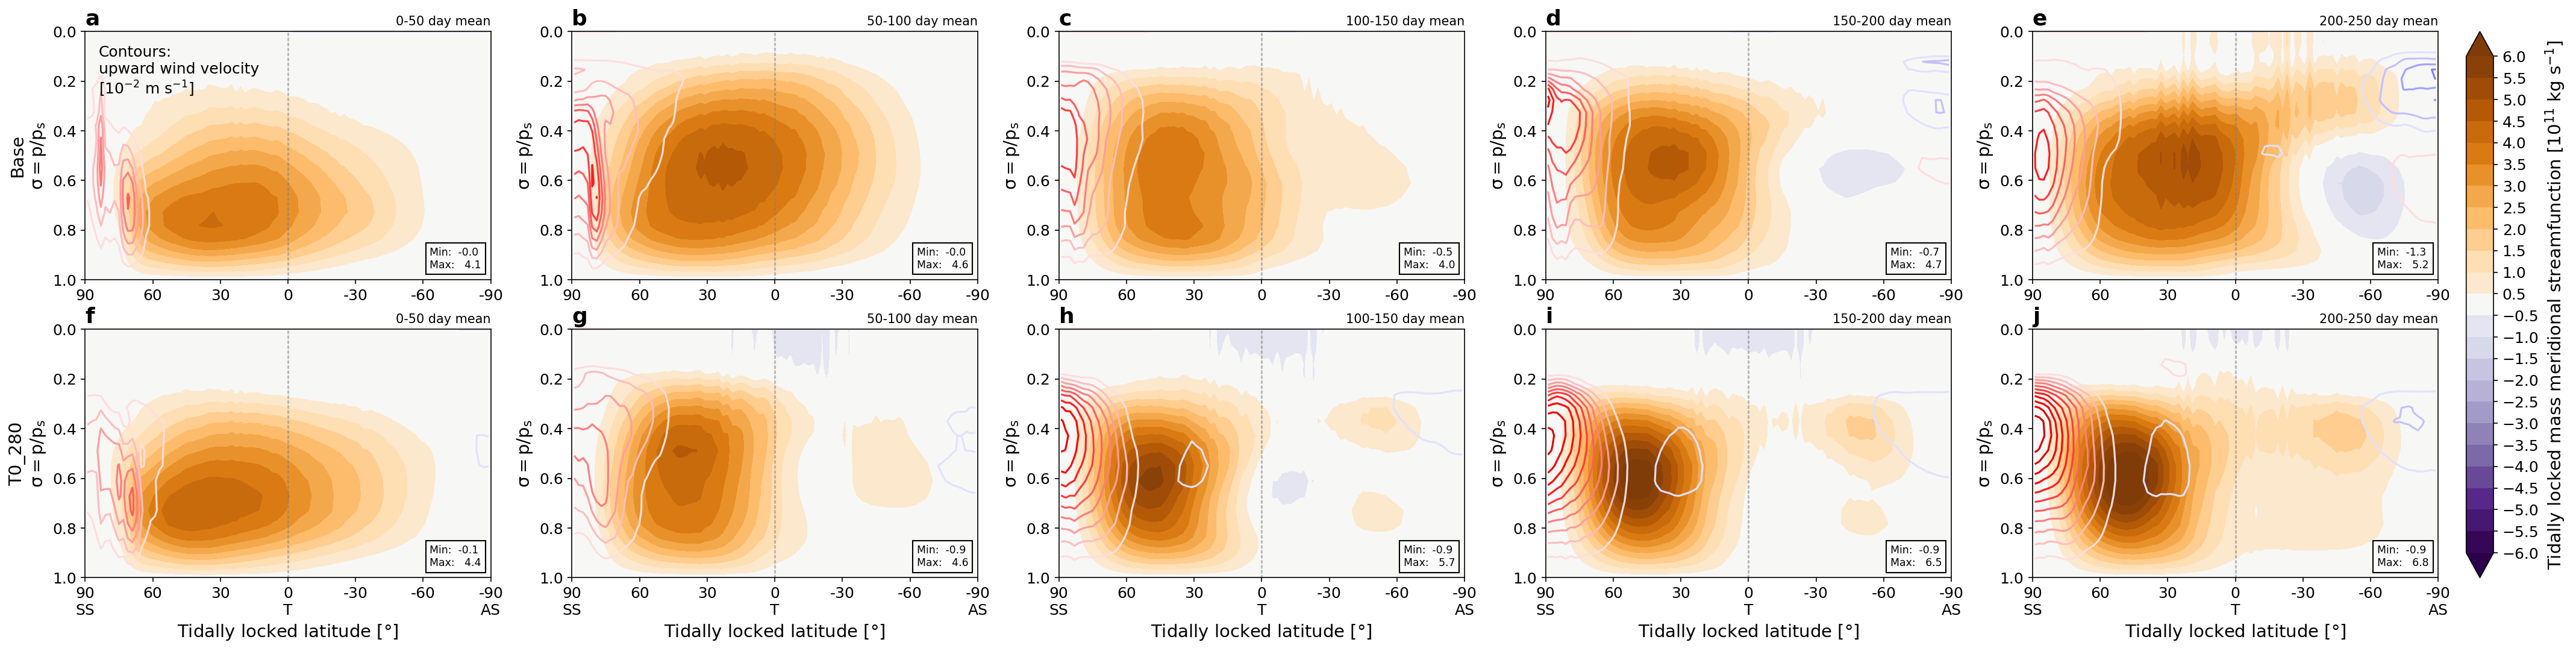

In [18]:
add_min_max = True

ncols = len(day_middle_list)
nrows = len(SIM_LABELS)

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4), squeeze=False
)

iletters = subplot_label_generator()
for (sim_label, sim_prop), axrow in zip(SIM_LABELS.items(), axs):
    the_run = runs[sim_label]
    _sigma_p = time_mean(spatial_mean(the_run.sigma_p))

    for ax, day_middle in zip(axrow, day_middle_list):
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        # ax.set_title(f"", **KW_MAIN_TTL)
        ax.set_ylim(1, 0)
        ax.set_xticks(tl_ticks)
        if ax.get_subplotspec().is_first_row():
            ax.set_xticklabels(tl_ticks)
        else:
            ax.set_xticklabels(tl_ticklabels)
        ax.set_xlim(90, -90)  # so that clockwise is positive
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"{sim_prop['title']}\n" "$\sigma=p/p_s$")
        else:
            ax.set_ylabel("$\sigma=p/p_s$")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Tidally locked latitude [$\degree$]")
        ax.axvline(**KW_ZERO_LINE)

        day_start = day_middle - day_half_window
        day_end = day_middle + day_half_window
        day_constr = iris.Constraint(
            **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
        )
        ax.set_title(f"{day_start}-{day_end} day mean", **KW_AUX_TTL)

        for i, (varkey, vardict) in enumerate(YZ_VRBL_PLOT.items()):
            cube = vardict["func"](the_run.extract(day_constr))
            cube.convert_units(tex2cf_units(vardict["tex_units"]))
            p0 = getattr(ax, vardict["method"])(
                the_run.coord.y.points,
                _sigma_p.data,
                cube.data,
                **vardict["kw_plt"],
            )
            if vardict["method"] == "contour":
                # clbls = ax.clabel(p0, fmt="%.2f")
                pass
            if (
                ax.get_subplotspec().is_first_col()
                and ax.get_subplotspec().is_first_row()
            ):
                if vardict["method"] == "contour":
                    ax.add_artist(
                        AnchoredText(
                            f"Contours:\n{vardict['title'].lower()}\n[{vardict['tex_units']}]",
                            loc="upper left",
                            frameon=False,
                        )
                    )
                elif vardict["method"] == "contourf":
                    cb = fig.colorbar(p0, ax=axs, pad=0.01)
                    cb.set_ticks(vardict["kw_plt"]["levels"])
                    cb.ax.set_ylabel(f"{vardict['title']} [{vardict['tex_units']}]")
            if add_min_max and i == 0:
                cube_min = cube.data.min()
                cube_max = cube.data.max()
                at = AnchoredText(
                    f"Min: {cube_min:>5.1f}\nMax: {cube_max:>5.1f}",
                    prop=dict(color="k", size="x-small"),
                    frameon=True,
                    loc="lower right",
                )
                at.patch.set_facecolor(mpl.colors.to_rgba(bg_color, alpha=0.75))
                ax.add_artist(at)

imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__{'_'.join(YZ_VRBL_PLOT.keys())}_{time_suffix}"
# figsave(fig, plotdir / imgname)

---

### Zonal momentum balance

In [ ]:
runs = {k: ZonalMomBudgetFluxForm.from_parent_class(v) for k, v in runs.items()}

In [ ]:
reduce = lambda cube: time_mean(
    spatial_mean(
        cube.extract(iris.Constraint(**{um.y: lambda x: 0 <= abs(x.point) <= 15}))
    )
)

In [ ]:
periods = {
    "first": {"days": [0, 20], "lim": [-0.8, 0.8]},
    "second": {"days": [20, 80], "lim": [-1.5, 1.5]},
    "third": {"days": [100, 200], "lim": [-2, 2]},
    "fourth": {"days": [250, 500], "lim": [-3, 3]},
}

In [ ]:
terms_to_show = [
    "mean_horiz",
    "mean_vert",
    "eddy_horiz",
    "eddy_vert",
    # "coriolis_horiz",
]

Saved to ../../plots/sa/ch111/ch111_spinup/ch111_spinup__base__zon_mom_bal__rho_u_zm__vprof_tropics.png


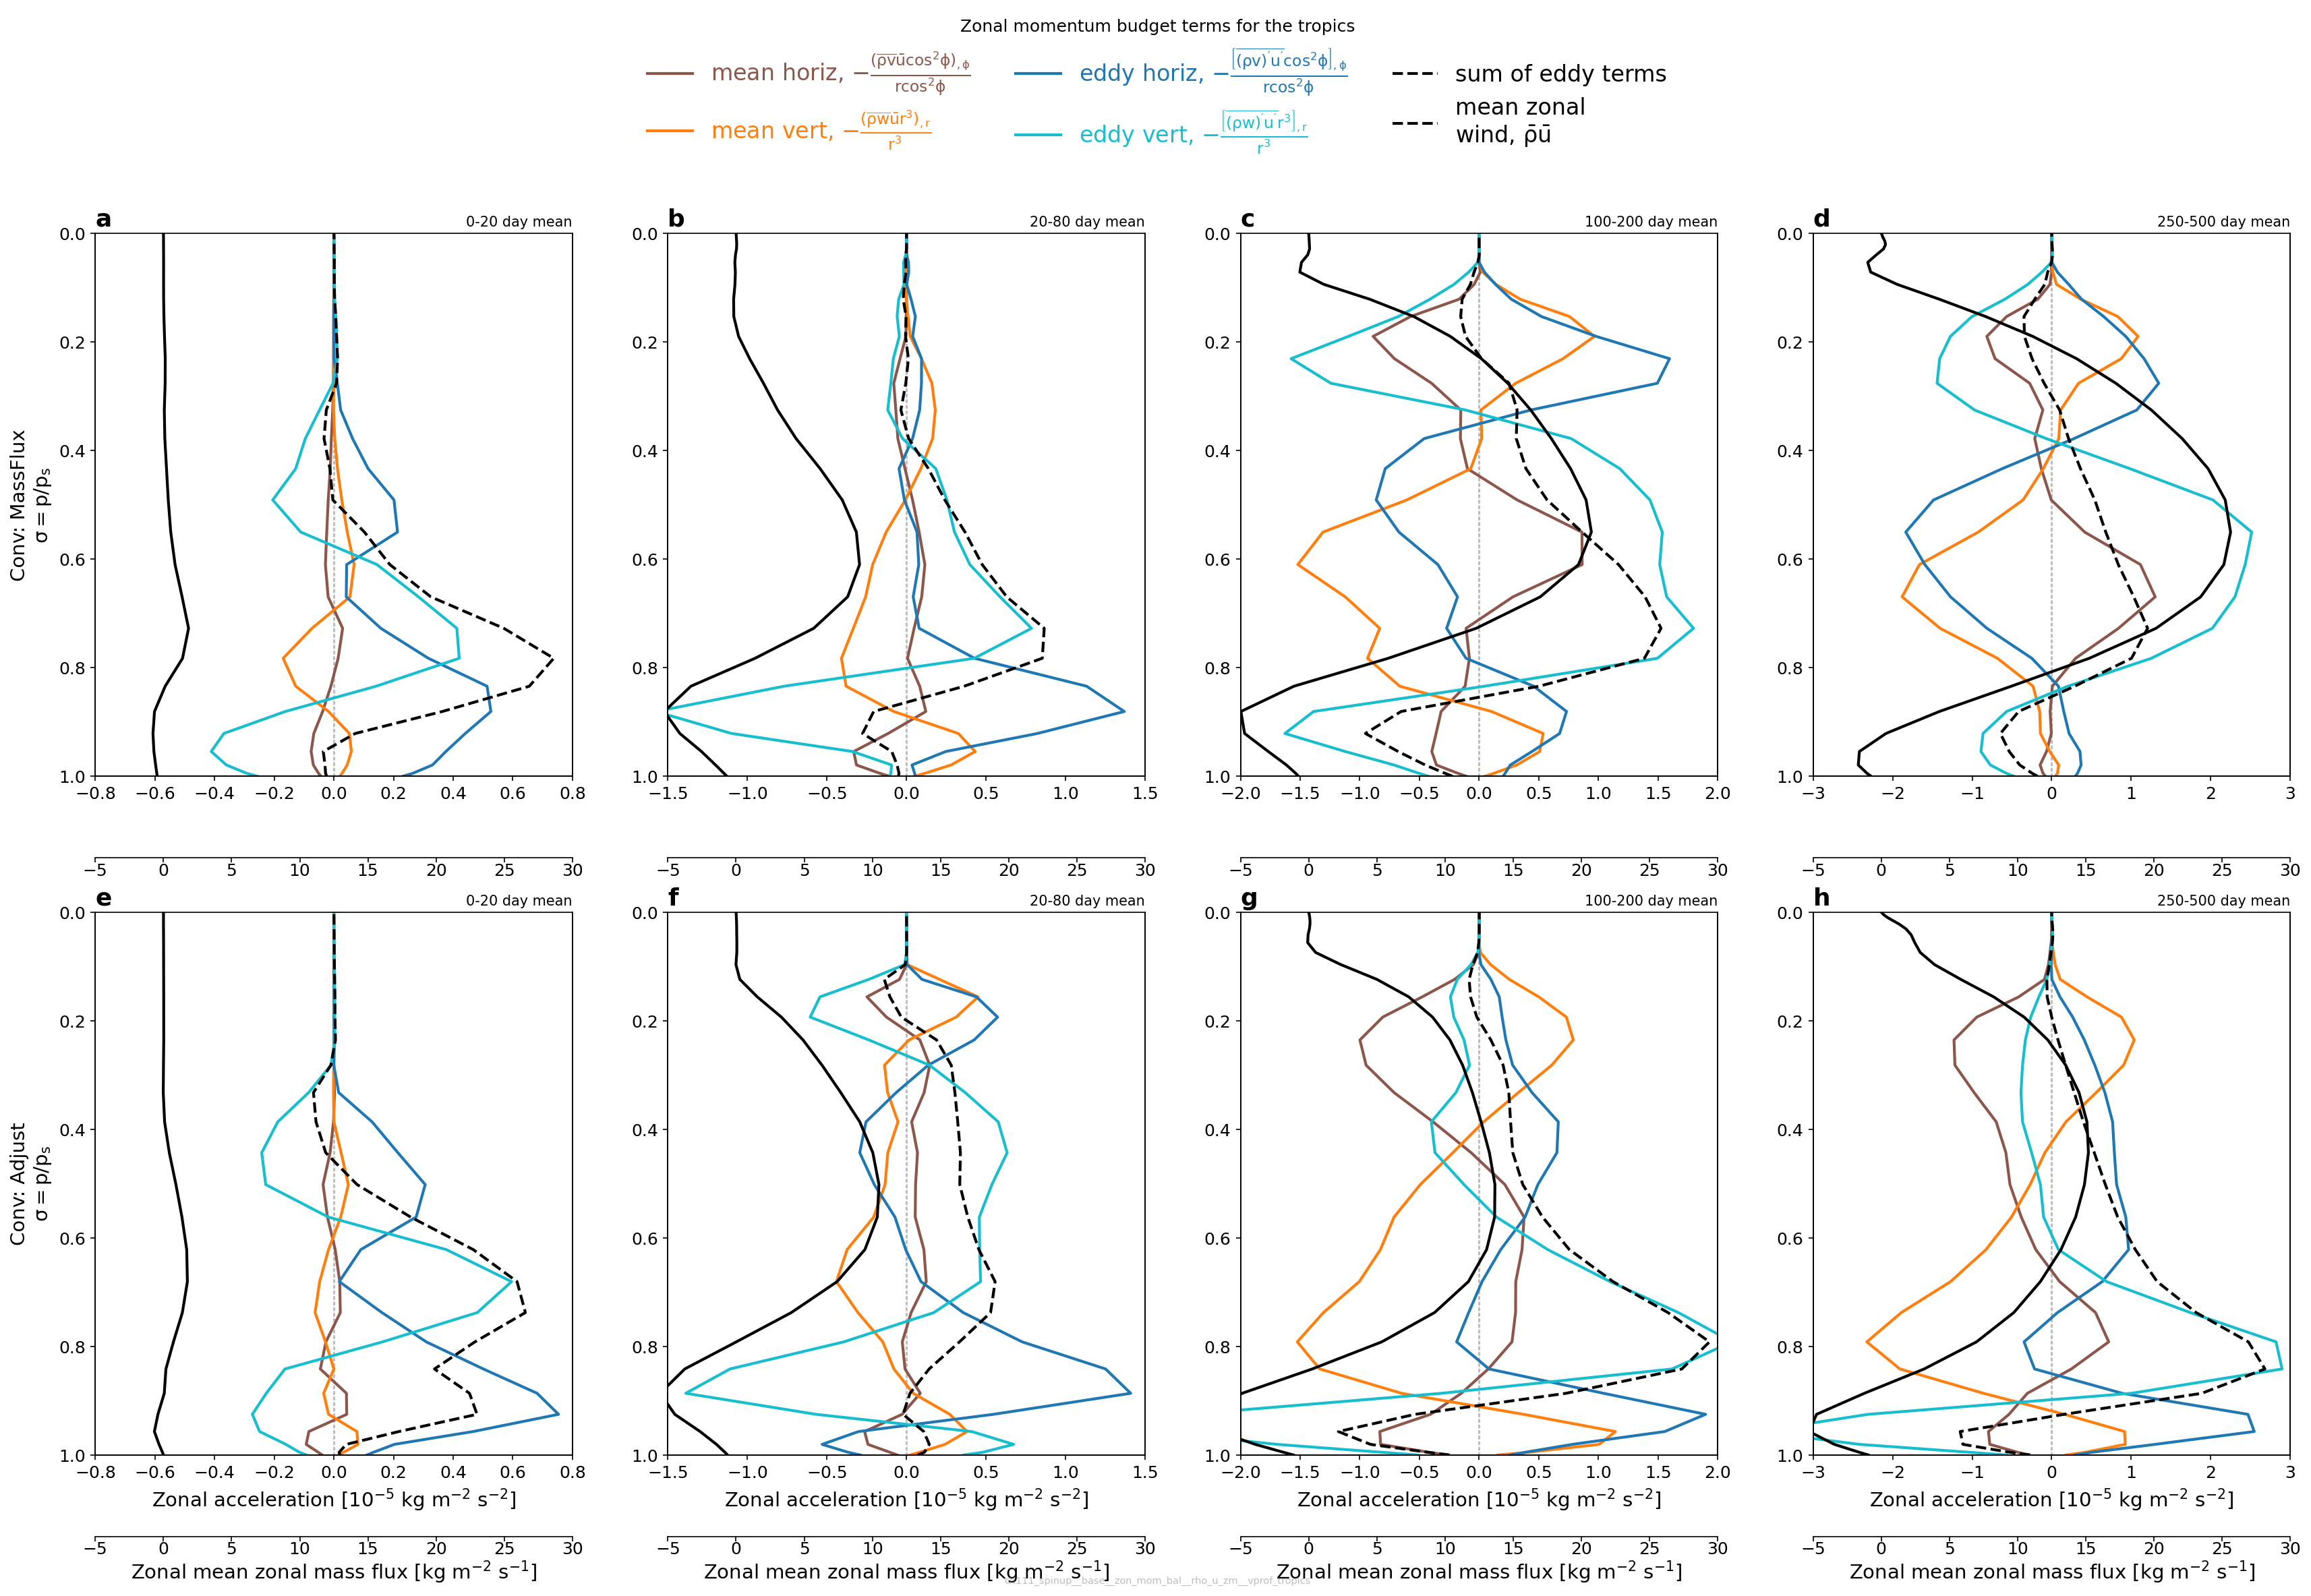

In [ ]:
opt_label = "base"
imgname = f"{img_prefix}__{opt_label}__zon_mom_bal__rho_u_zm__vprof_tropics"
ylim = [1, 0]
kw_common = dict(linewidth=2)
tex_units = "$10^{-5}$ $kg$ $m^{-2}$ $s^{-2}$"
tex_units2 = "$kg$ $m^{-2}$ $s^{-1}$"
ncols = len(periods)
nrows = 2
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(ncols * 7, nrows * 8),
    gridspec_kw=dict(hspace=0.25),
)
iletters = subplot_label_generator()
for suite_label, axrow in zip(SUITE_LABELS.keys(), axs):
    the_run = runs[f"{suite_label}_{opt_label}"]
    _sigma_p = time_mean(spatial_mean(the_run.sigma_p))
    rho_u_zm = the_run.u_zm * zonal_mean(the_run.dens)
    # du_dt_zm = deriv(rho_u_zm, um.t)
    # du_dt_zm.convert_units(tex2cf_units(tex_units))
    for (period_key, period_prop), ax in zip(periods.items(), axrow):
        ax2 = ax.twiny()
        ax2.spines["top"].set_position(("axes", -0.15))
        ax2.set_xlim([-5, 30])
        ax2.tick_params(axis="x", direction="in", pad=-15)
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        ax.axvline(0, **KW_ZERO_LINE)
        ax.set_ylim(ylim)
        ax.set_xlim(period_prop.get("lim"))
        day_start, day_end = period_prop["days"]
        day_constr = iris.Constraint(
            **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
        )

        ax.set_title(f"{day_start}-{day_end} day mean", **KW_AUX_TTL)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"{SUITE_LABELS[suite_label]['title']}\n" "$\sigma=p/p_s$")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(f"Zonal acceleration [{tex_units}]")
            ax2.set_xlabel(f"Zonal mean zonal mass flux [{tex_units2}]", labelpad=-30)

        term_sum = []
        for i, term_label in enumerate(terms_to_show):
            term = the_run[term_label]
            kw_plt = dict(color=term.attributes["color"])
            # Collapse diagnostics
            cube = reduce(term.extract(day_constr))
            cube.convert_units(tex2cf_units(tex_units))
            # Plot diagnostics
            ax.plot(
                cube.data,
                _sigma_p.data,
                **kw_common,
                **kw_plt,
            )
            if term_label.startswith("eddy"):
                term_sum.append(cube)
        cube = sum(term_sum)
        ax.plot(
            cube.data,
            _sigma_p.data,
            color="k",
            linestyle="--",
            **kw_common,
        )
        cube = reduce(rho_u_zm.extract(day_constr))
        cube.convert_units(tex2cf_units(tex_units2))
        ax2.plot(
            cube.data,
            _sigma_p.data,
            color="k",
            linestyle="-",
            **kw_common,
        )
        # ax.plot(
        #     reduce(du_dt_zm.extract(day_constr)).data,
        #     _sigma_p.data,
        #     color="k",
        #     linestyle="-",
        #     **kw_common,
        # )

add_custom_legend(
    fig,
    {
        **{
            f'{the_run[term_label].name().replace("_", " ")}, ${the_run[term_label].attributes["tex"]}$': {
                **kw_common,
                "color": the_run[term_label].attributes["color"],
            }
            for term_label in terms_to_show
        },
        **{
            "sum of eddy terms": dict(
                color="k",
                linestyle="--",
                **kw_common,
            ),
            "mean zonal\nwind, "
            + r"$\bar{\rho} \bar{u}$": dict(
                color="k",
                linestyle="--",
                **kw_common,
            ),
        },
    },
    loc="upper center",
    bbox_to_anchor=(0.5, 1.025),
    frameon=False,
    ncol=3,
    title="Zonal momentum budget terms for the tropics",
)

figsave(fig, plotdir / imgname)

##### Mean state, Y-Z vertical cross sections

In [114]:
day_half_window = 5
day_middle_list = np.arange(6, 25) * day_half_window * 2 + day_half_window
day_middle_list

array([ 65,  75,  85,  95, 105, 115, 125, 135, 145, 155, 165, 175, 185,
       195, 205, 215, 225, 235, 245])

In [ ]:
for opt_label in ["base", "sens-noradcld"]:
    for day_middle in day_middle_list:
        day_start = day_middle - day_half_window
        day_end = day_middle + day_half_window
        day_constr = iris.Constraint(
            **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
        )
        time_suffix = f"{day_start:04d}_{day_end:04d}_days_mean"
        imgname = f"{img_prefix}__{opt_label}__yz_zon_mom_bal_{time_suffix}"
        reduce = lambda cube: time_mean(cube.extract(day_constr))

        factor = 1e5
        tex_factor = "$10^{-5}$ "

        ncols = 5
        nrows = 2

        fig, axs = plt.subplots(
            ncols=ncols, nrows=nrows, figsize=(ncols * 7, nrows * 3.5), squeeze=False
        )
        axs[0, 0].add_artist(
            AnchoredText(
                f"{day_start}-{day_end} day mean", loc="upper left", frameon=False
            )
        )

        iletters = subplot_label_generator()
        for suite_label, axrow in zip(SUITE_LABELS.keys(), axs):
            the_run = runs[f"{suite_label}_{opt_label}"]
            _sigma_p = time_mean(spatial_mean(the_run.sigma_p))

            for ax, term_label in zip(axrow, the_run.term_labels):
                cube_a = reduce(the_run[term_label])
                term_dict = cube_a.attributes
                term_color = term_dict.get("color", fg_color)
                ax.set_title(SUITE_LABELS[suite_label]["title"], **KW_MAIN_TTL)
                ax.set_title(
                    f"{cube_a.name().replace('_', ' ')}",
                    color=term_color,
                    **KW_AUX_TTL,
                )
                ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
                at = AnchoredText(
                    f'${term_dict["tex"]}$',
                    prop=dict(color=term_color),
                    frameon=True,
                    pad=0.2,
                    loc=4,
                )
                at.patch.set_facecolor(mpl.colors.to_rgba(bg_color, alpha=0.75))
                ax.add_artist(at)
                ax.set_ylim([1, 0])
                ax.set_xticks(YLOCS)
                ax.set_xticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS])
                if ax.is_first_col():
                    ax.set_ylabel("$\sigma=p/p_s$")
                if ax.is_last_row():
                    ax.set_xlabel("Latitude [$\degree$]")

                ax.axvline(**KW_ZERO_LINE)

                cntrf = ax.contourf(
                    the_run.coord.y.points,
                    _sigma_p.data,
                    cube_a.data * factor,
                    cmap=cm.vik,
                    levels=linspace_pm1(8) * 4,
                    extend="both",
                )

                cube_b = reduce(the_run.u_zm)
                cntr = ax.contour(
                    the_run.coord.y.points,
                    _sigma_p.data,
                    cube_b.data,
                    colors=mpl.colors.to_hex(fg_color),
                    linewidths=0.5,
                    levels=linspace_pm1(20) * 100,
                )
                clbls = ax.clabel(cntr, fmt="%.0f", colors=mpl.colors.to_hex(fg_color))
        fig.subplots_adjust(wspace=0.1)
        cb = fig.colorbar(cntrf, ax=axs, pad=0.010, aspect=40)
        cb.set_ticks(linspace_pm1(8) * 4)
        cb.ax.set_ylabel(f"Zonal acceleration [{tex_factor}{the_run.tex_units}]")
        figsave(fig, plotdir / imgname)

##### Upper troposphere timeseries

In [35]:
reduce = lambda cube: meridional_mean(
    vertical_mean(
        cube.extract(l_range_constr(7, 13) & tropics),
    )
)

In [36]:
KW_ROLL_MEAN = dict(window=40, cutoff=0.075)

Saved to ../../plots/sa/ch111/ch111_spinup/ch111_spinup__base__zon_mom_bal__up_trop_tropics.png


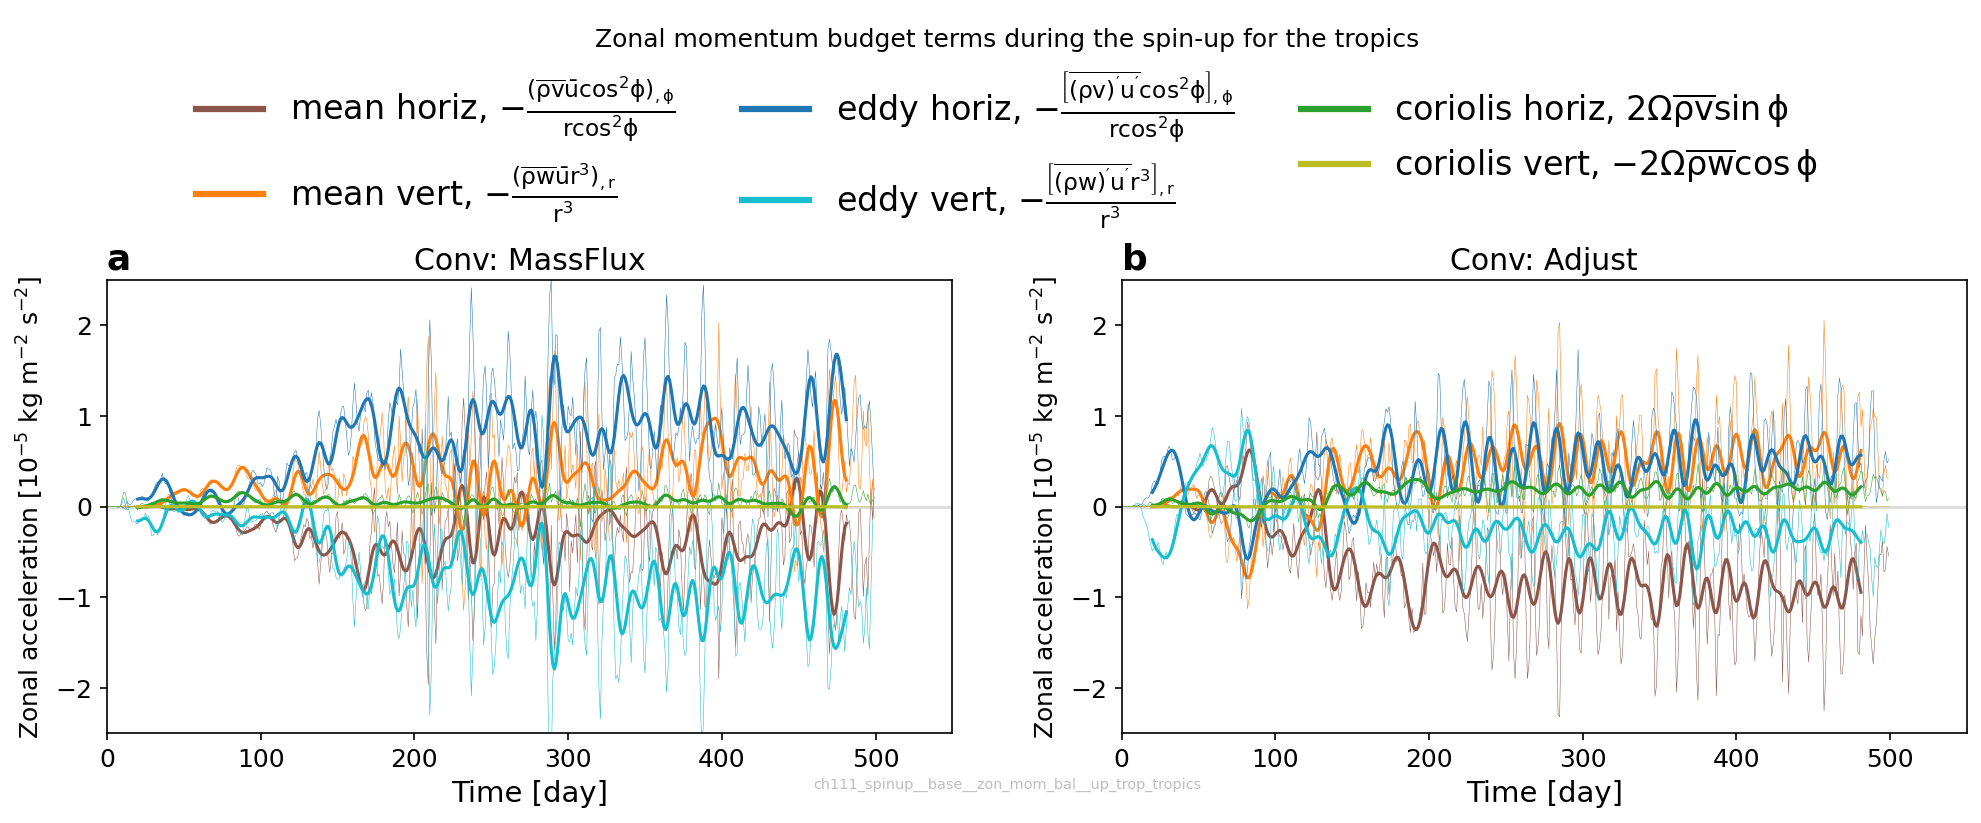

In [41]:
opt_label = "base"
imgname = f"{img_prefix}__{opt_label}__zon_mom_bal__up_trop_tropics"
xlim = [0, 550]
ylim = [-2.5, 2.5]
factor = 1e5
tex_factor = "$10^{-5}$ "
ncols = 2
nrows = 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4))
iletters = subplot_label_generator()
for suite_label, ax in zip(SUITE_LABELS.keys(), axs.flat):
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_title(SUITE_LABELS[suite_label]["title"], **KW_MAIN_TTL)
    ax.set_xlabel("Time [day]")
    the_run = runs[f"{suite_label}_{opt_label}"]
    for i, term_label in enumerate(the_run.term_labels):
        term = the_run[term_label]
        kw_plt = dict(color=term.attributes["color"])
        # Collapse diagnostics
        cube = reduce(term)
        cube_rm = rolling_mean(cube, um.t, **KW_ROLL_MEAN)
        # Plot diagnostics
        ax.set_ylabel(
            f"Zonal acceleration [{tex_factor}{the_run.tex_units}]",
            fontsize="medium",
        )
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        if i == 0:
            ax.hlines(0, *xlim, alpha=0.25, color="tab:grey")
        ax.plot(
            get_cube_rel_days(cube),
            cube.data * factor,
            linewidth=0.25,
            **kw_plt,
        )
        ax.plot(
            get_cube_rel_days(cube_rm) + KW_ROLL_MEAN["window"] / 2,
            cube_rm.data * factor,
            linewidth=1.5,
            **kw_plt,
        )

add_custom_legend(
    fig,
    {
        f'{the_run[term_label].name().replace("_", " ")}, ${the_run[term_label].attributes["tex"]}$': {
            "linewidth": 3,
            "color": the_run[term_label].attributes["color"],
        }
        for term_label in the_run.term_labels
    },
    loc="upper center",
    bbox_to_anchor=(0.5, 1.35),
    frameon=False,
    ncol=3,
    title="Zonal momentum budget terms during the spin-up for the tropics",
)

figsave(fig, plotdir / imgname)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Saved to ../plots/sa/bx000/bx000_spinup_hab1/bx000_spinup_hab1_outliers__y_v_int_hrts.png


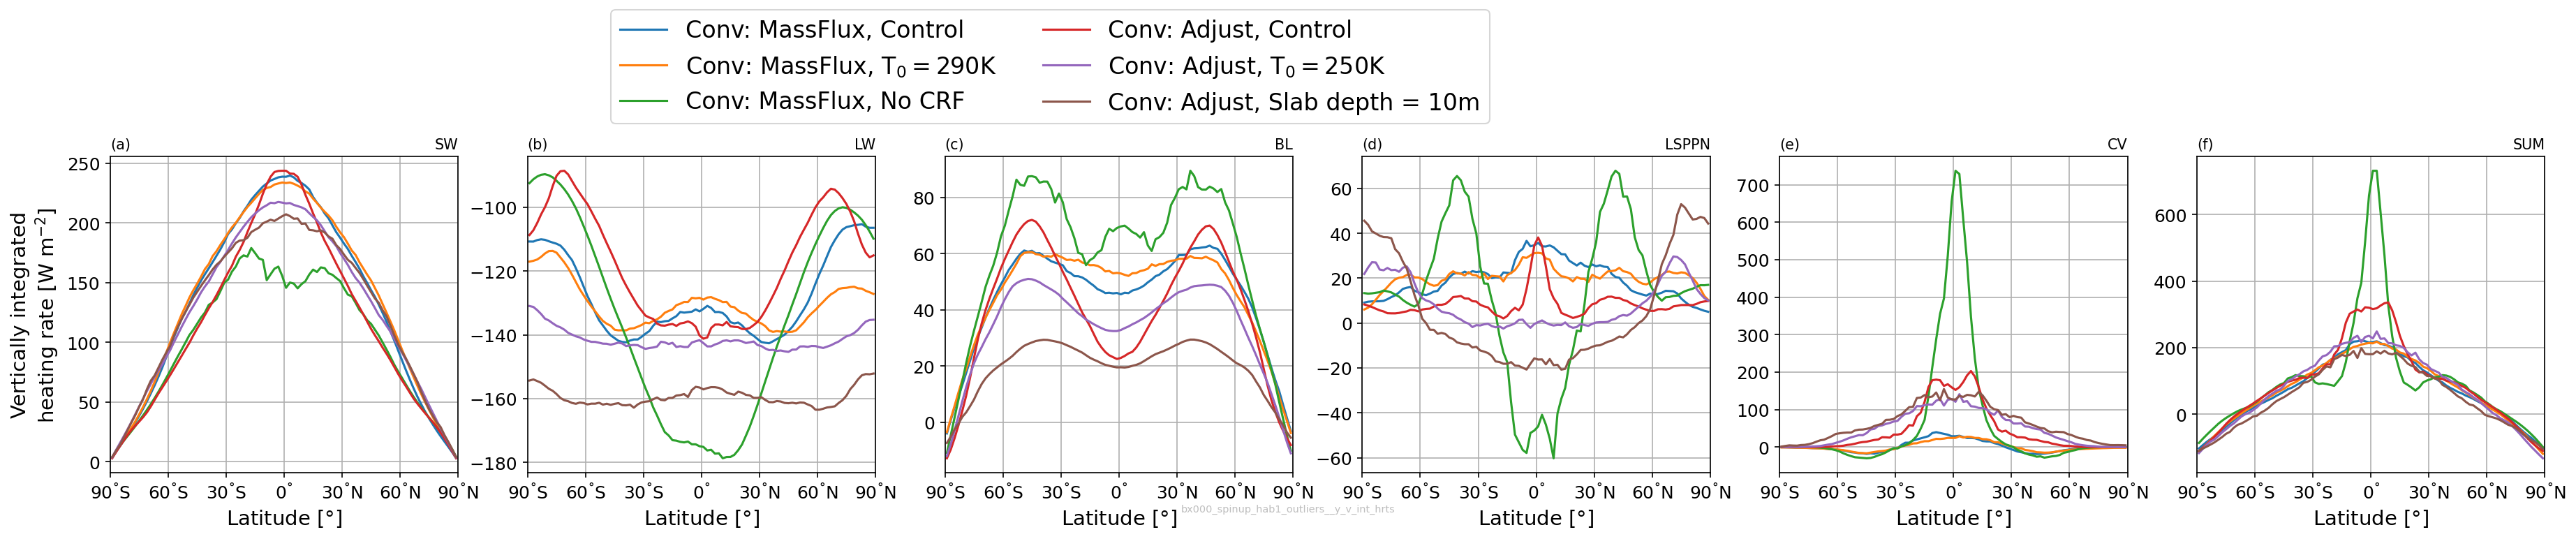

In [71]:
_constr = (
    iris.Constraint(**{um.fcst_prd: lambda x: 300 <= x.point / 24 <= 500})
    & DAYSIDE.constraint
    & l_range_constr(0, 17)
)
main_terms = ["dt_sw", "dt_lw", "dt_bl", "dt_lsppn", "dt_cv", "dt_sum"]

sim_labels = [
    "hab1_base",
    "hab1_sens-t290k",
    "hab1_sens-noradcld",
    "hab1_llcs_all_rain_base",
    "hab1_llcs_all_rain_sens-t250k",
    "hab1_llcs_all_rain_sens-hcapsea4e7",
]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
nrows = 1
ncols = len(main_terms)
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), constrained_layout=False
)
for sim_label, color in tqdm(zip(sim_labels, colors)):
    opt_label = sim_label.split("_")[-1]
    suite_label = sim_label.replace(f"_{opt_label}", "")
    the_run = runs[sim_label]
    iletters = subplot_label_generator()
    for term, ax in tqdm(zip(main_terms, axs), leave=False):
        if term == "dt_sum":
            cube = sum([the_run[i].extract(_constr) for i in main_terms[:-1]])
        else:
            cube = the_run[term].extract(_constr)
        cube = vert_int_hrts(cube, the_run["dens"].extract(_constr))
        cube = time_mean(zonal_mean(cube))
        ax.plot(
            cube.coord(um.y).points,
            cube.data,
            color=color,
            label=f"{SUITE_LABELS[suite_label]['title']}, {OPT_LABELS[opt_label]['title']}",
        )
        ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
        # ax.set_title(SUITE_LABELS[suite_label]["title"], **KW_MAIN_TTL)
        ax.set_title(term.replace("dt_", "").upper(), **KW_AUX_TTL)
        if ax.is_first_col():
            ax.set_ylabel(
                "Vertically integrated\nheating rate [$W$ $m^{-2}$]",
            )
        ax.set_xticks(YLOCS)
        ax.set_xticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS])
        ax.set_xlabel("Latitude [$\degree$]")
        ax.set_xlim(-90, 90)
        ax.grid(True)
leg = axs[0].legend(loc="upper right", bbox_to_anchor=(4.0, 1.5), ncol=2)
imgname = f"{img_prefix}_outliers__y_v_int_hrts"
figsave(fig, plotdir / imgname)